In [110]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [111]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [149]:
df = pd.read_csv('/home/thu/LaptrinhAI/Final_term/hanoi-aqi-weather-data.csv',
                 parse_dates=['Local Time', 'UTC Time'],
                 index_col=['Local Time'])
df.head()

UTC Time   City Country Code          Timezone  \
Local Time                                                                      
2023-06-08 00:00:00 2023-06-07 17:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 01:00:00 2023-06-07 18:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 02:00:00 2023-06-07 19:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 03:00:00 2023-06-07 20:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 04:00:00 2023-06-07 21:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   

                     AQI     CO   NO2    O3  PM10  PM25   SO2  Clouds  \
Local Time                                                              
2023-06-08 00:00:00  118  168.7  32.3  74.7  52.5  42.0  57.3      37   
2023-06-08 01:00:00  115  169.8  32.0  66.0  51.3  41.0  64.0      50   
2023-06-08 02:00:00  112  166.7  29.3  63.7  50.0  40.0  66.0      62   
2023-06-08 03:00:00  121  163.6  26.7  61.3  53.8  43.0  68.0      75   
2023-06-08 04:00:00  134  160.5  24.0  59.0  60.0  48.0  70.0      87   

                     Precipitation  Pressure  Relative Humidity  Temperature  \
Local Time                                                                     
2023-06-08 00:00:00            0.5      1004                 87         29.3   
2023-06-08 01:00:00            1.0      1004                 88         29.0   
2023-06-08 02:00:00            1.0      1003                 89         28.9   
2023-06-08 03:00:00            0.5      1003                 90         28.7   
2023-06-08 04:00:00            0.0      1003                 92         28.6   

                     UV Index  Wind Speed  
Local Time                                 
2023-06-08 00:00:00       0.0        1.33  
2023-06-08 01:00:00       0.0        1.00  
2023-06-08 02:00:00       0.0        0.66  
2023-06-08 03:00:00       0.0        0.33  
2023-06-08 04:00:00       0.0        1.20

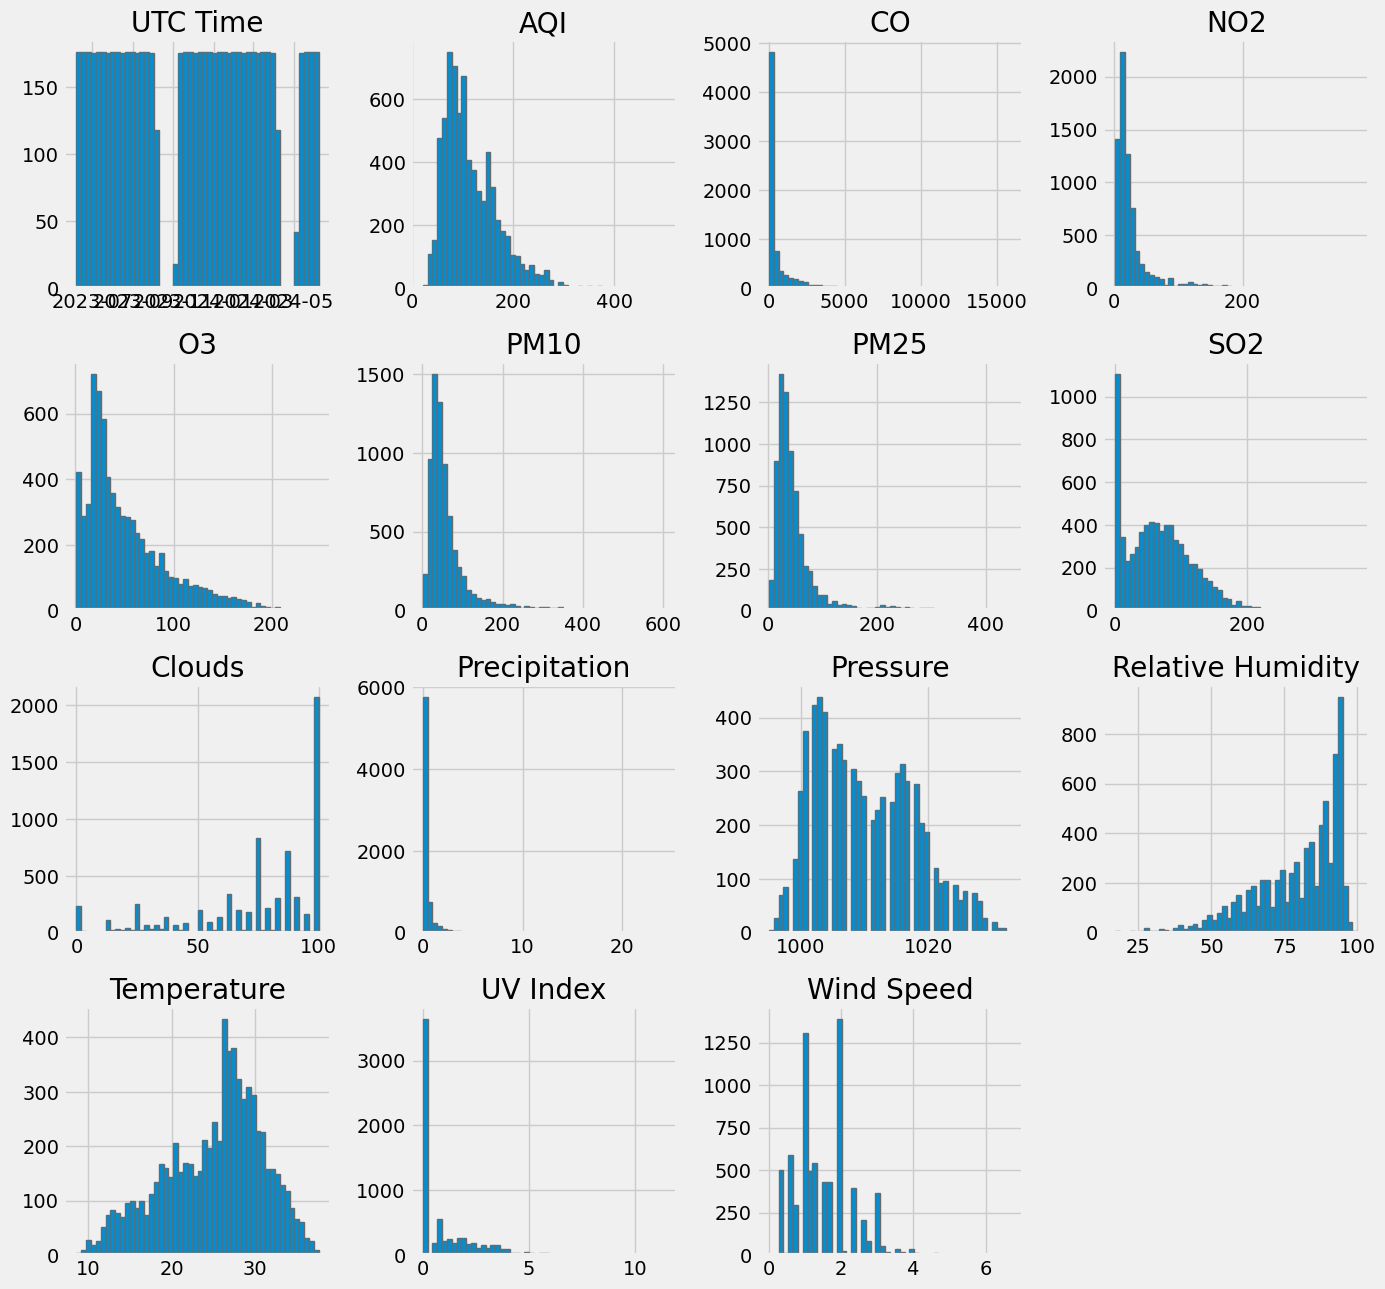

In [150]:
df.hist(bins=50, figsize=(15,15));

# Data Wrangling

## Missing Value

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7323 entries, 2023-06-08 00:00:00 to 2024-06-08 00:00:00
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   UTC Time           7323 non-null   datetime64[ns]
 1   City               7323 non-null   object        
 2   Country Code       7323 non-null   object        
 3   Timezone           7323 non-null   object        
 4   AQI                7323 non-null   int64         
 5   CO                 7323 non-null   float64       
 6   NO2                7323 non-null   float64       
 7   O3                 7323 non-null   float64       
 8   PM10               7323 non-null   float64       
 9   PM25               7323 non-null   float64       
 10  SO2                7323 non-null   float64       
 11  Clouds             7323 non-null   int64         
 12  Precipitation      7323 non-null   float64       
 13  Pressure           7323 non

In [152]:
df.isnull().sum()

UTC Time             0
City                 0
Country Code         0
Timezone             0
AQI                  0
CO                   0
NO2                  0
O3                   0
PM10                 0
PM25                 0
SO2                  0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV Index             0
Wind Speed           0
dtype: int64

In [153]:
df.shape

(7323, 18)

In [154]:
df.describe()

UTC Time          AQI            CO          NO2  \
count                           7323  7323.000000   7323.000000  7323.000000   
mean   2023-11-28 20:58:02.015567360   116.585689    689.296736    29.826806   
min              2023-06-07 17:00:00    21.000000      9.000000     2.000000   
25%              2023-08-22 23:30:00    76.000000    129.600000    11.000000   
50%              2023-12-08 05:00:00   102.000000    202.000000    17.300000   
75%              2024-02-22 11:30:00   151.000000    605.000000    30.000000   
max              2024-06-07 17:00:00   500.000000  15956.200000   378.000000   
std                              NaN    55.780160   1252.939417    37.224108   

                O3         PM10         PM25          SO2       Clouds  \
count  7323.000000  7323.000000  7323.000000  7323.000000  7323.000000   
mean     52.687396    64.847016    50.093733    67.637799    72.991260   
min       1.000000     1.300000     1.000000     0.000000     0.000000   
25%      21.300000    30.600000    23.500000    26.000000    61.500000   
50%      39.000000    46.000000    35.000000    63.000000    79.000000   
75%      73.000000    72.500000    54.500000    99.000000   100.000000   
max     248.000000   604.000000   446.000000   368.000000   100.000000   
std      42.986051    62.242520    51.428854    50.246253    28.078716   

       Precipitation     Pressure  Relative Humidity  Temperature  \
count    7323.000000  7323.000000        7323.000000  7323.000000   
mean        0.358562  1010.077154          79.274887    25.037881   
min         0.000000   995.000000          17.000000     8.600000   
25%         0.000000  1004.000000          70.000000    20.800000   
50%         0.000000  1009.000000          84.000000    26.200000   
75%         0.000000  1016.000000          92.000000    29.200000   
max        24.250000  1033.000000         100.000000    37.600000   
std         1.269800     7.758417          15.033467     5.917315   

          UV Index   Wind Speed  
count  7323.000000  7323.000000  
mean      1.260085     1.545976  
min       0.000000     0.000000  
25%       0.000000     1.000000  
50%       0.600000     1.330000  
75%       2.000000     2.000000  
max      11.400000     6.700000  
std       1.837839     0.806536

Xác định biến mục tiêu

<Axes: >

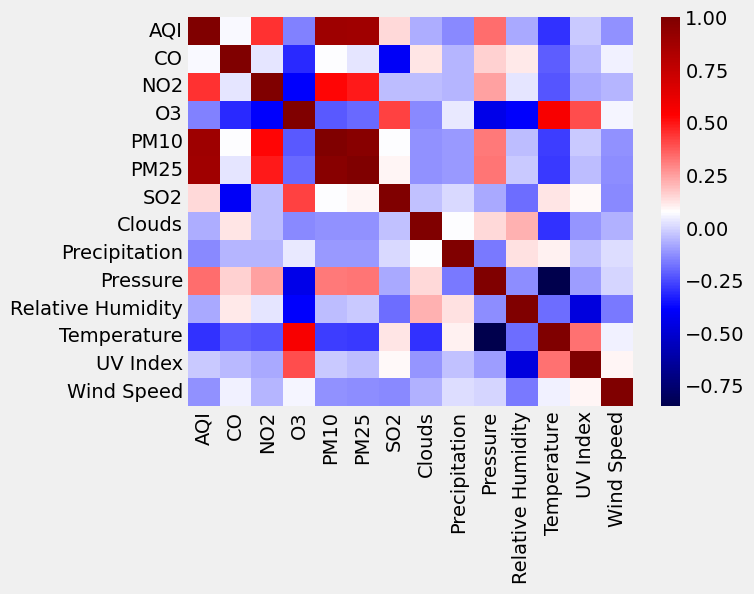

In [155]:
df_num = df[['AQI', 'CO', 'NO2',
       'O3', 'PM10', 'PM25', 'SO2', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed']]
data = df_num.copy(deep=True)
sns.heatmap(data.corr(), cmap='seismic')

In [156]:
data.drop(columns=['CO', 'Clouds', 'UV Index', 'SO2', 'Precipitation'], inplace=True)
data

AQI   NO2    O3  PM10   PM25  Pressure  \
Local Time                                                    
2023-06-08 00:00:00  118  32.3  74.7  52.5  42.00      1004   
2023-06-08 01:00:00  115  32.0  66.0  51.3  41.00      1004   
2023-06-08 02:00:00  112  29.3  63.7  50.0  40.00      1003   
2023-06-08 03:00:00  121  26.7  61.3  53.8  43.00      1003   
2023-06-08 04:00:00  134  24.0  59.0  60.0  48.00      1003   
...                  ...   ...   ...   ...    ...       ...   
2024-06-07 20:00:00   67  21.7  27.3  35.4  20.09      1003   
2024-06-07 21:00:00   55  19.4  29.1  23.9  14.10      1004   
2024-06-07 22:00:00   49  20.3  35.2  20.6  11.73      1004   
2024-06-07 23:00:00   51  20.0  29.7  21.7  12.36      1004   
2024-06-08 00:00:00   54  38.5  39.1  19.0  13.80      1003   

                     Relative Humidity  Temperature  Wind Speed  
Local Time                                                       
2023-06-08 00:00:00                 87         29.3        1.33  
2023-06-08 01:00:00                 88         29.0        1.00  
2023-06-08 02:00:00                 89         28.9        0.66  
2023-06-08 03:00:00                 90         28.7        0.33  
2023-06-08 04:00:00                 92         28.6        1.20  
...                                ...          ...         ...  
2024-06-07 20:00:00                 89         28.2        2.00  
2024-06-07 21:00:00                 92         27.5        2.00  
2024-06-07 22:00:00                 95         26.7        2.00  
2024-06-07 23:00:00                 95         26.8        1.66  
2024-06-08 00:00:00                 95         26.9        1.33  

[7323 rows x 9 columns]

In [157]:
# calculate quantile from each attributes
def calculate_quantile (i, data):
    Q1 = data[[i]].quantile(0.25)[0]
    Q3 = data[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = data[[i]].min()[0]
    max = data[[i]].max()[0]
    min_IQR = Q1 - 1.5*IQR
    max_IQR = Q3 + 1.5*IQR
    
    return Q1, Q3, min, max, min_IQR, max_IQR

# delete first and last rows to avoid missing value extrapolation
data.drop(index=[data.index[0], data.index[data.shape[0]-1]], inplace=True)

# find and interpolate the outliers
for i in data.columns:
    print('\nAttribute-',i,':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculate_quantile(i, data)
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    print('min IQR = %.2f' % min_IQR)
    print('max IQR = %.2f' % max_IQR)
    if (min < min_IQR):
        print('---> Low outlier is found = %.2f' % min)
    if (max > max_IQR):
        print('---> High outlier is found = %.2f' % max)
    
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x

    def convert_nan_HUM (x, max_IQR=100.0, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x
    
    if (i == 'HUM'):
        data[i] = data[i].map(convert_nan_HUM)
        data[i] = data[i].interpolate(method='linear')
    if (i != 'HUM'):
        data[i] = data[i].map(convert_nan)
        data[i] = data[i].interpolate(method='linear')
         
    if (len(data[data[i].isnull()][i]) == 0):
        print('################  Outliers have been interpolated  ################')


Attribute- AQI :
Q1 = 76.00
Q3 = 151.00
min IQR = -36.50
max IQR = 263.50
---> High outlier is found = 500.00
################  Outliers have been interpolated  ################

Attribute- NO2 :
Q1 = 11.00
Q3 = 30.00
min IQR = -17.50
max IQR = 58.50
---> High outlier is found = 378.00
################  Outliers have been interpolated  ################

Attribute- O3 :
Q1 = 21.30
Q3 = 73.00
min IQR = -56.25
max IQR = 150.55
---> High outlier is found = 248.00
################  Outliers have been interpolated  ################

Attribute- PM10 :
Q1 = 30.60
Q3 = 72.50
min IQR = -32.25
max IQR = 135.35
---> High outlier is found = 604.00
################  Outliers have been interpolated  ################

Attribute- PM25 :
Q1 = 23.50
Q3 = 54.50
min IQR = -23.00
max IQR = 101.00
---> High outlier is found = 446.00
################  Outliers have been interpolated  ################

Attribute- Pressure :
Q1 = 1004.00
Q3 = 1016.00
min IQR = 986.00
max IQR = 1034.00
################  Outlier

## 1. AQI PRediction

In [158]:
# log transform để xử lý thông tin sai lệch

dataset = np.log1p(data[['AQI']].values)
dataset.shape

(7321, 1)

In [161]:
data['AQI'].max()

263.0

<Figure size 1200x500 with 0 Axes>

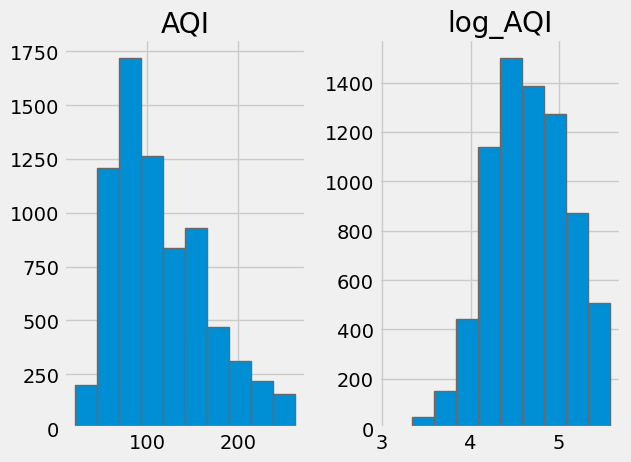

In [162]:
# tạo khung dữ liệu mới để so sánh với dữ liệu gốc và dữ liệu log transfor
dist_df = pd.DataFrame({'AQI' : data['AQI'].values, 'log_AQI' : dataset[:,0]})

# Biểu đồ histogram phân tích độ lệch chuẩn của dữ liệu gốc và log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

Nhận xét: Từ hình trên ta có thể thấy dữ liệu gốc của AQI có phân phối lệch chuẩn, cụ thể có đuôi kéo dài về phía AQI có giá trị cao. Biểu đổ bên phải là dữ liệu sau khi áp dụng phép biến đổi log, có tâm đối xứng hơn.(biến đổi log được sử dụng để chuẩn hoá dữ liệu, giảm độ lệch chuẩn)

In [163]:
#Chia data
# # 75% for training, 25% for testing

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [164]:
train

array([[4.75359019],
       [4.72738782],
       [4.80402104],
       ...,
       [4.39444915],
       [4.49980967],
       [4.20469262]])

In [165]:
test

array([[4.27666612],
       [4.26267988],
       [4.46590812],
       ...,
       [4.02535169],
       [3.91202301],
       [3.95124372]])

In [127]:
# chuyển đổi mảng giả trị thành ma trận dataset

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [166]:
# tạo input và output cho mô hình

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [167]:
trainX

array([[4.75359019],
       [4.72738782],
       [4.80402104],
       ...,
       [4.56434819],
       [4.34380542],
       [4.39444915]])

In [130]:
trainY

array([4.72738782, 4.80402104, 4.90527478, ..., 4.34380542, 4.39444915,
       4.49980967])

In [131]:
# reshape mảng đầu vào thành: [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [132]:
# tạo và điều chỉnh LSTM Neural Network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
172/172 - 1s - 5ms/step - loss: 20.5070
Epoch 2/500
172/172 - 0s - 1ms/step - loss: 15.6075
Epoch 3/500
172/172 - 0s - 1ms/step - loss: 10.7959
Epoch 4/500
172/172 - 0s - 896us/step - loss: 7.0173
Epoch 5/500
172/172 - 0s - 948us/step - loss: 4.1862
Epoch 6/500
172/172 - 0s - 887us/step - loss: 2.1924
Epoch 7/500
172/172 - 0s - 905us/step - loss: 1.1120
Epoch 8/500
172/172 - 0s - 1ms/step - loss: 0.5806
Epoch 9/500
172/172 - 0s - 1ms/step - loss: 0.3364
Epoch 10/500
172/172 - 0s - 1ms/step - loss: 0.2322
Epoch 11/500
172/172 - 0s - 1ms/step - loss: 0.1927
Epoch 12/500
172/172 - 0s - 1ms/step - loss: 0.1786
Epoch 13/500
172/172 - 0s - 999us/step - loss: 0.1742
Epoch 14/500
172/172 - 0s - 946us/step - loss: 0.1726
Epoch 15/500
172/172 - 0s - 906us/step - loss: 0.1716
Epoch 16/500
172/172 - 0s - 886us/step - loss: 0.1704
Epoch 17/500
172/172 - 0s - 896us/step - loss: 0.1693
Epoch 18/500
172/172 - 0s - 816us/step - loss: 0.1682
Epoch 19/500
172/172 - 0s - 827us/step - loss: 0.1

### Model performance

In [133]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Train Score: 24.97 RMSE
Test Score: 28.95 RMSE


In [134]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
28.95 < 45.77


In [135]:
dataset.shape[0]-1

7320

In [136]:
len(testPredictPlot)

7321

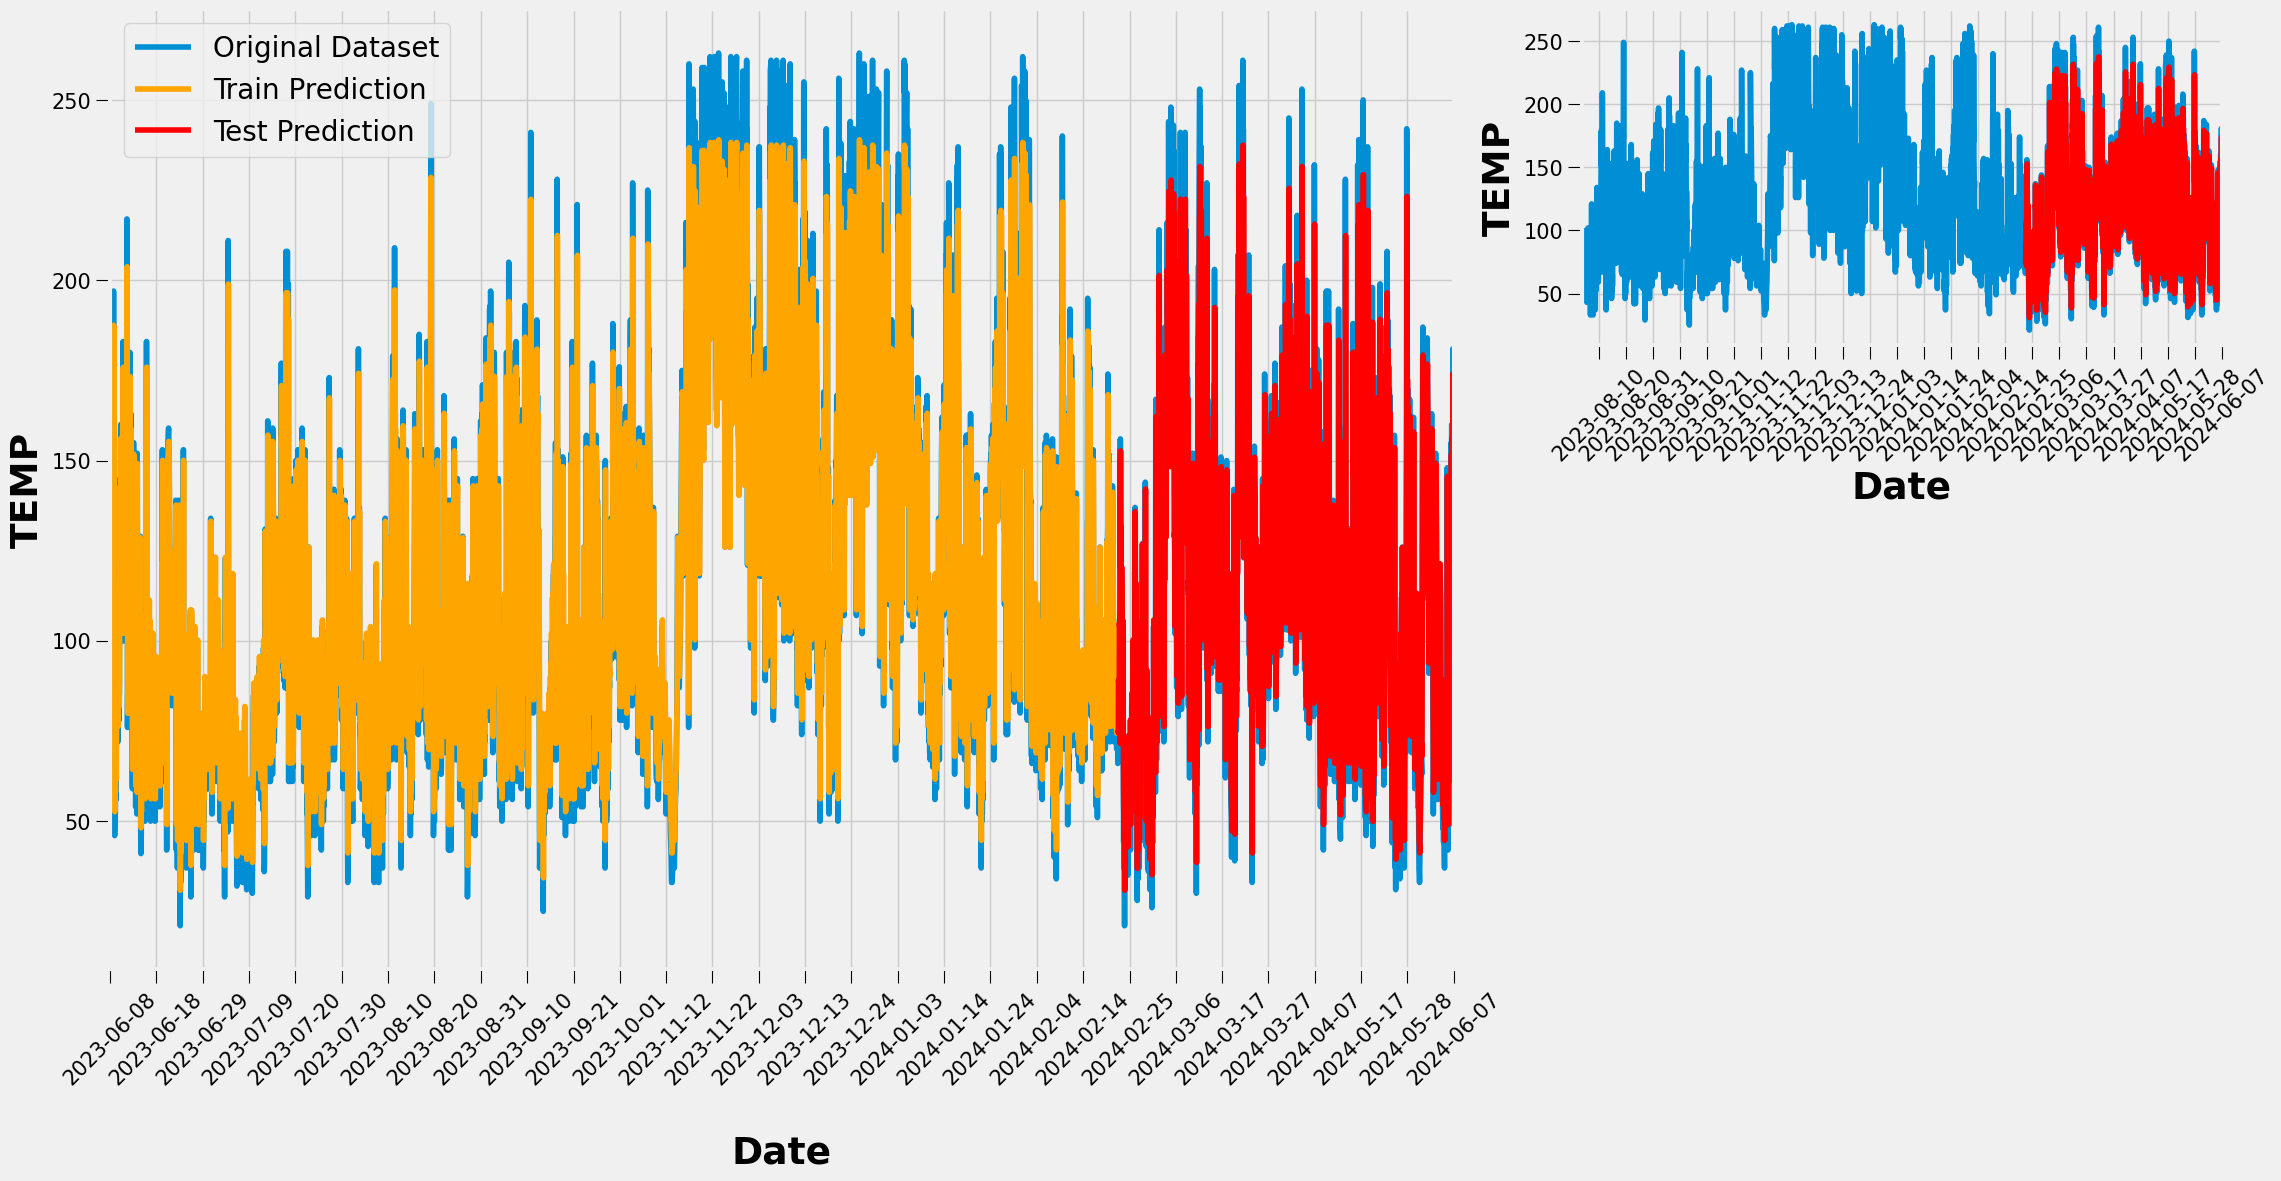

In [137]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 30)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])

ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 2. PM2.5 Prediction

In [243]:
data.columns

Index(['AQI', 'NO2', 'O3', 'PM10', 'PM25', 'Pressure', 'Relative Humidity',
       'Temperature', 'Wind Speed'],
      dtype='object')

In [244]:
dataset = np.log1p(data[['PM25']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

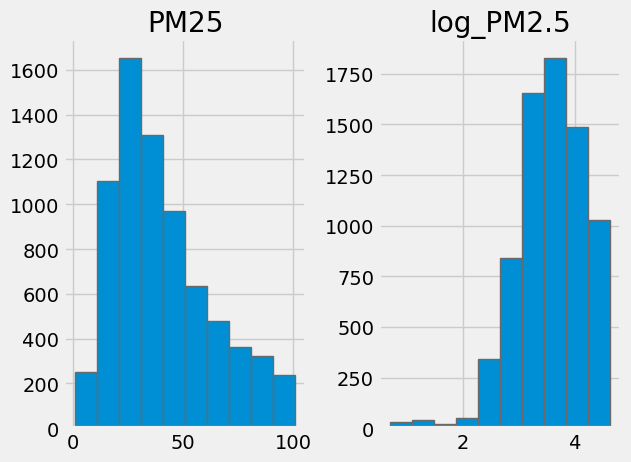

In [245]:
dist_df = pd.DataFrame({'PM25' : data['PM25'].values, 'log_PM2.5' : dataset[:,0]})
plt.figure(figsize=(12,5))
dist_df.hist();

In [246]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [247]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [248]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [249]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 2s - 9ms/step - loss: 11.8937
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: 7.6141
Epoch 3/1000
172/172 - 0s - 2ms/step - loss: 3.9683
Epoch 4/1000
172/172 - 0s - 2ms/step - loss: 2.0151
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 1.0359
Epoch 6/1000
172/172 - 0s - 2ms/step - loss: 0.5422
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.3176
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.2662
Epoch 9/1000
172/172 - 0s - 2ms/step - loss: 0.2489
Epoch 10/1000
172/172 - 0s - 2ms/step - loss: 0.2296
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.2037
Epoch 12/1000
172/172 - 0s - 2ms/step - loss: 0.1701
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.1377
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.1178
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.1049
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0972
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0925
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0898
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.0882
E

KeyboardInterrupt: 

### Model Performance

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
Train Score: 25.07 RMSE
Test Score: 28.83 RMSE


RMSE của testset lớn hơn trainset => overfitting. 

In [ ]:
testPredict.shape

(1829, 1)

In [ ]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
28.83 < 45.77


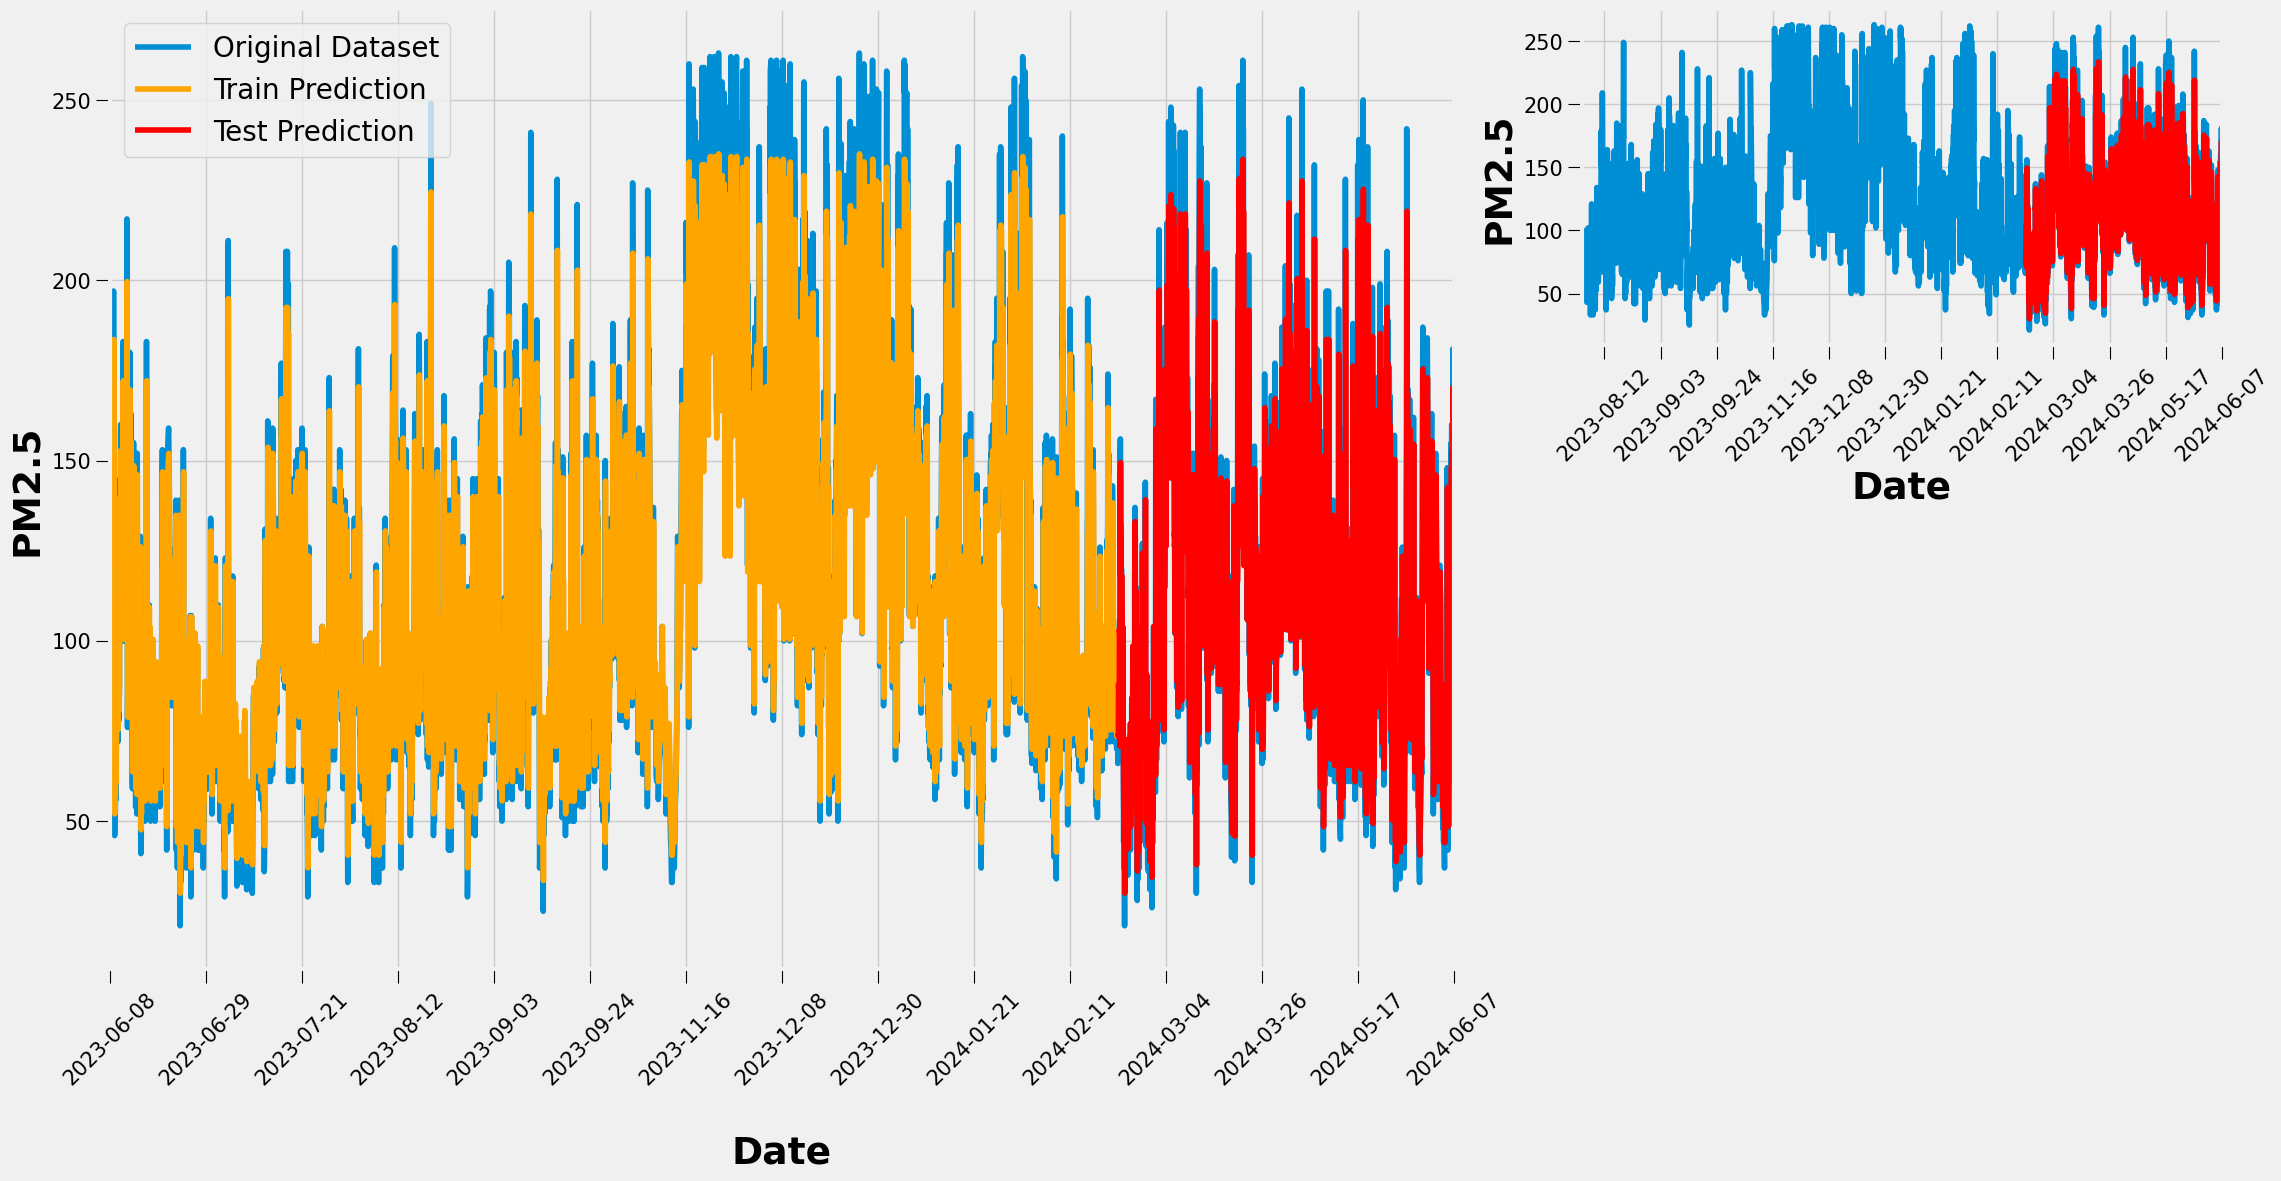

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

In [ ]:
testPredictPlot.shape

(7321, 1)

## 3. Temperature prediction

In [174]:
dataset = np.log1p(data[['Temperature']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

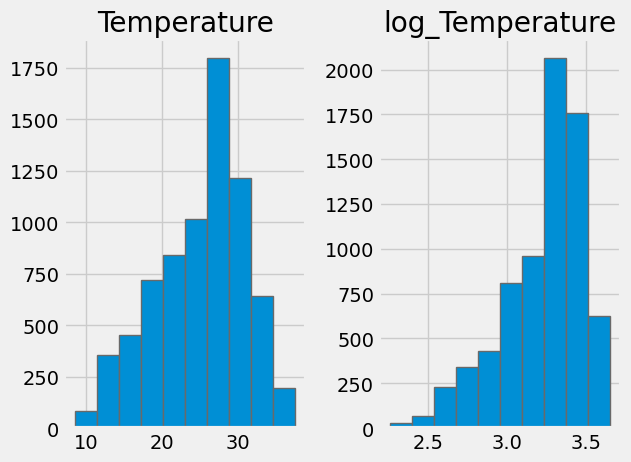

In [175]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Temperature' : data['Temperature'].values, 'log_Temperature' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [176]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [177]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [178]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [179]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1500, batch_size=32, verbose=2)

Epoch 1/1500
172/172 - 1s - 8ms/step - loss: 9.2464
Epoch 2/1500
172/172 - 0s - 2ms/step - loss: 5.2354
Epoch 3/1500
172/172 - 0s - 2ms/step - loss: 1.6329
Epoch 4/1500
172/172 - 0s - 1ms/step - loss: 0.2404
Epoch 5/1500
172/172 - 0s - 1ms/step - loss: 0.0512
Epoch 6/1500
172/172 - 0s - 1ms/step - loss: 0.0370
Epoch 7/1500
172/172 - 0s - 1ms/step - loss: 0.0361
Epoch 8/1500
172/172 - 0s - 1ms/step - loss: 0.0356
Epoch 9/1500
172/172 - 0s - 1ms/step - loss: 0.0352
Epoch 10/1500
172/172 - 0s - 1ms/step - loss: 0.0347
Epoch 11/1500
172/172 - 0s - 2ms/step - loss: 0.0341
Epoch 12/1500
172/172 - 0s - 2ms/step - loss: 0.0334
Epoch 13/1500
172/172 - 0s - 1ms/step - loss: 0.0325
Epoch 14/1500
172/172 - 0s - 2ms/step - loss: 0.0315
Epoch 15/1500
172/172 - 0s - 1ms/step - loss: 0.0305
Epoch 16/1500
172/172 - 0s - 1ms/step - loss: 0.0291
Epoch 17/1500
172/172 - 0s - 1ms/step - loss: 0.0275
Epoch 18/1500
172/172 - 0s - 1ms/step - loss: 0.0257
Epoch 19/1500
172/172 - 0s - 1ms/step - loss: 0.0235
Ep

### Model Performance

In [180]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
Train Score: 0.70 RMSE
Test Score: 0.62 RMSE


Cả RMSE của trainset và testset đều tương đối nhỏ => Với đầu vào là Temperature mô hình đưa ra dự đoán ổn tốt hơn so với đầu vào là PM2.5

In [181]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
0.62 < 5.52


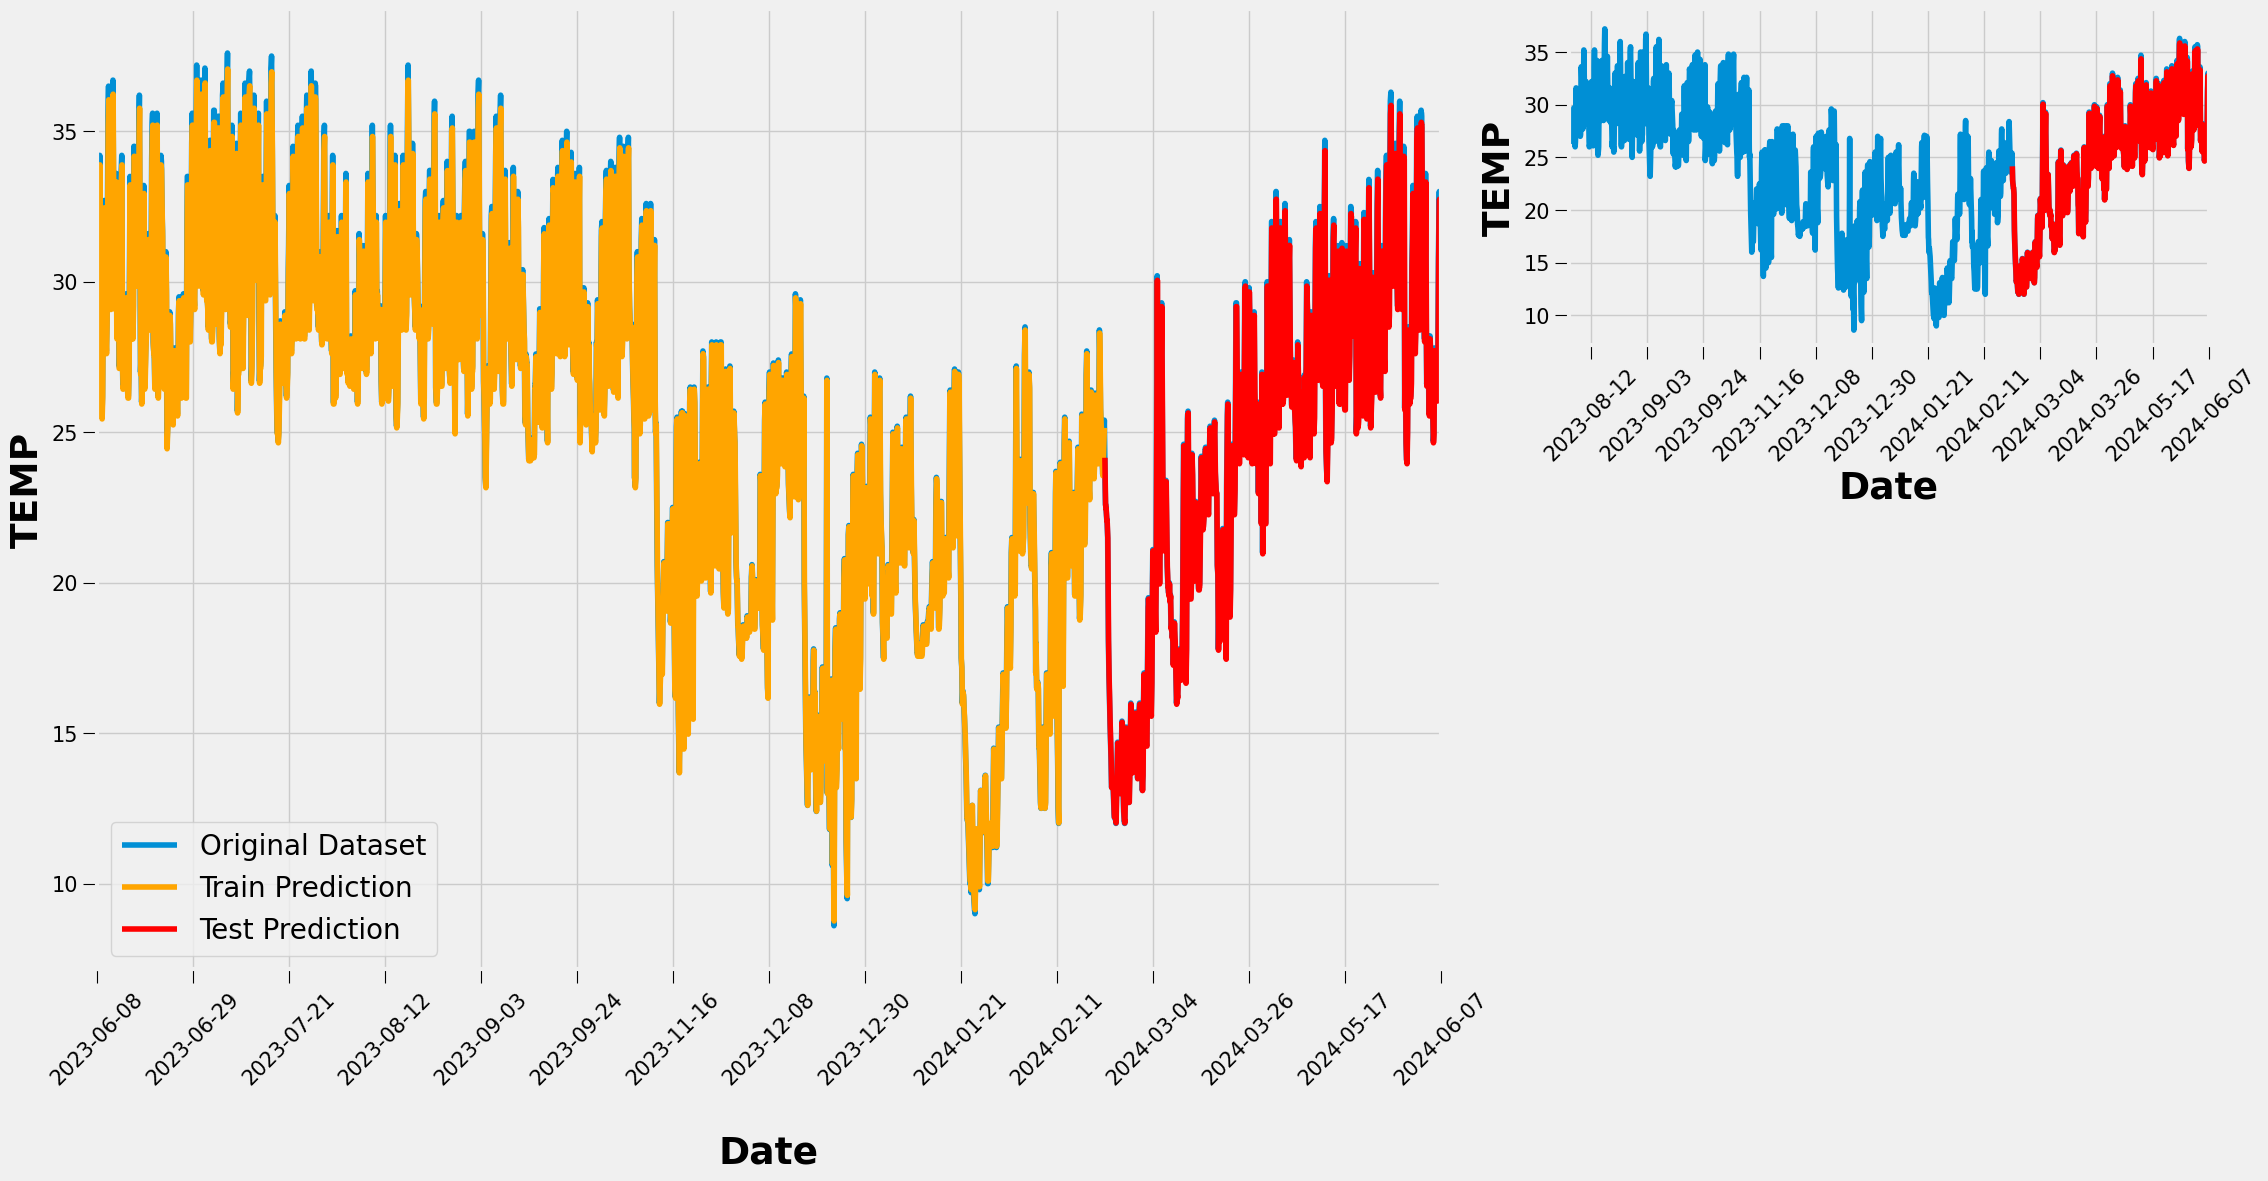

In [182]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 4. NO2 Prediction

In [183]:
dataset = np.log1p(data[['NO2']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

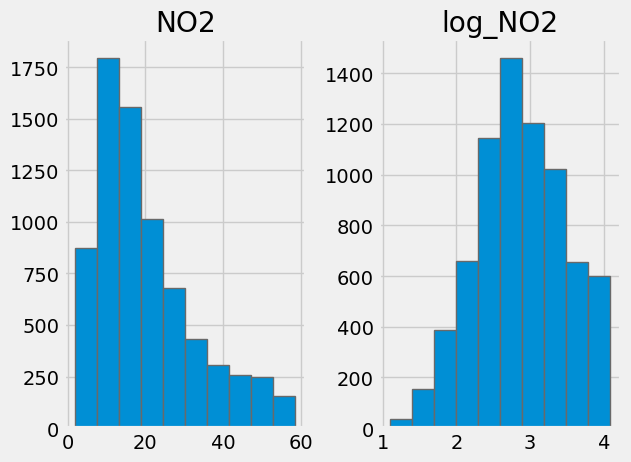

In [184]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'NO2' : data['NO2'].values, 'log_NO2' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [185]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [186]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [187]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [188]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 9ms/step - loss: 7.5089
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: 4.4366
Epoch 3/1000
172/172 - 0s - 2ms/step - loss: 1.7400
Epoch 4/1000
172/172 - 0s - 2ms/step - loss: 0.5767
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 0.2841
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.2211
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.2068
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.1994
Epoch 9/1000
172/172 - 0s - 2ms/step - loss: 0.1901
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.1784
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.1645
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.1495
Epoch 13/1000
172/172 - 0s - 2ms/step - loss: 0.1344
Epoch 14/1000
172/172 - 0s - 2ms/step - loss: 0.1192
Epoch 15/1000
172/172 - 0s - 2ms/step - loss: 0.1061
Epoch 16/1000
172/172 - 0s - 2ms/step - loss: 0.0950
Epoch 17/1000
172/172 - 0s - 2ms/step - loss: 0.0867
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0808
Epoch 19/1000
172/172 - 0s - 2ms/step - loss: 0.0768
Ep

### Model Performance

In [189]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 5.27 RMSE
Test Score: 10.26 RMSE


Tương tự như với đầu vào là Temperature, mô hình dự đoán ổn

In [190]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
10.26 < 13.71


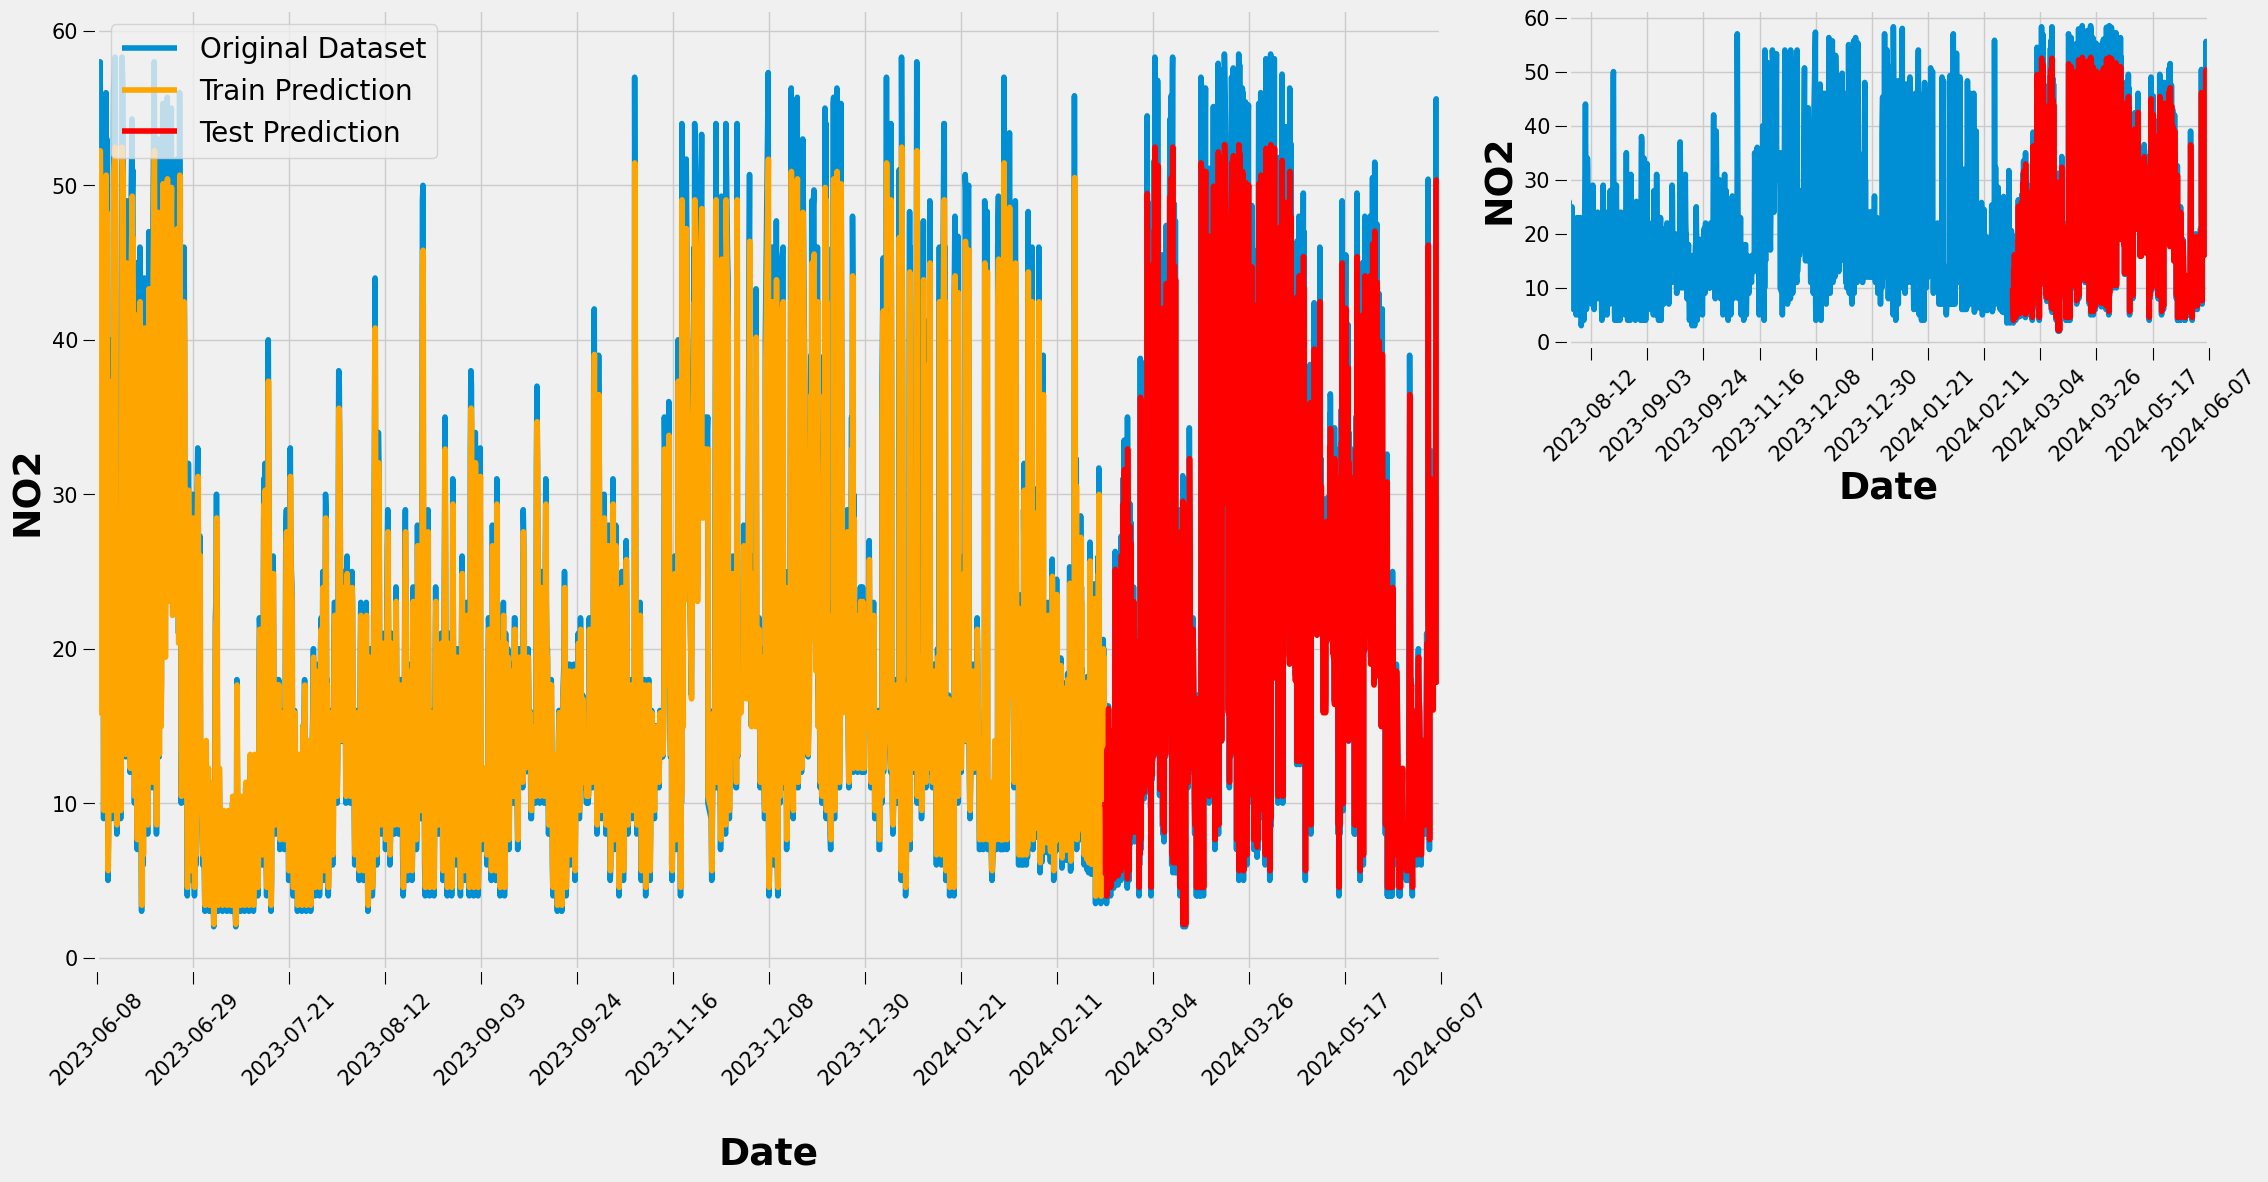

In [191]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('NO2', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('NO2', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 5. O3 Prediction

In [192]:
dataset = np.log1p(data[['O3']].values)
dataset.shape

(7321, 1)

In [ ]:
data['O3']

<Figure size 1200x500 with 0 Axes>

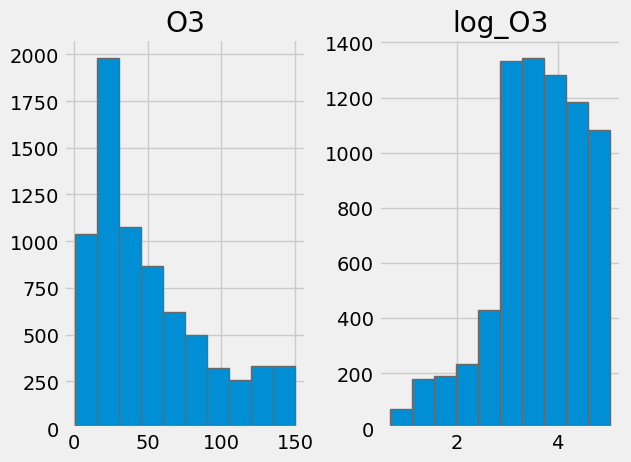

In [193]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'O3' : data['O3'].values, 'log_O3' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [194]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [195]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [196]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [197]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 2s - 10ms/step - loss: 13.9619
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: 9.9023
Epoch 3/1000
172/172 - 0s - 2ms/step - loss: 5.6810
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 2.9167
Epoch 5/1000
172/172 - 0s - 2ms/step - loss: 0.8408
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.4760
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.4401
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.4091
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.3741
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.3322
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.3021
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.2820
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.2686
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.2614
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.2567
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.2521
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.2498
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.2481
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.2462


### Model Performance

In [198]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 14.74 RMSE
Test Score: 15.40 RMSE


In [199]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
15.40 < 26.39


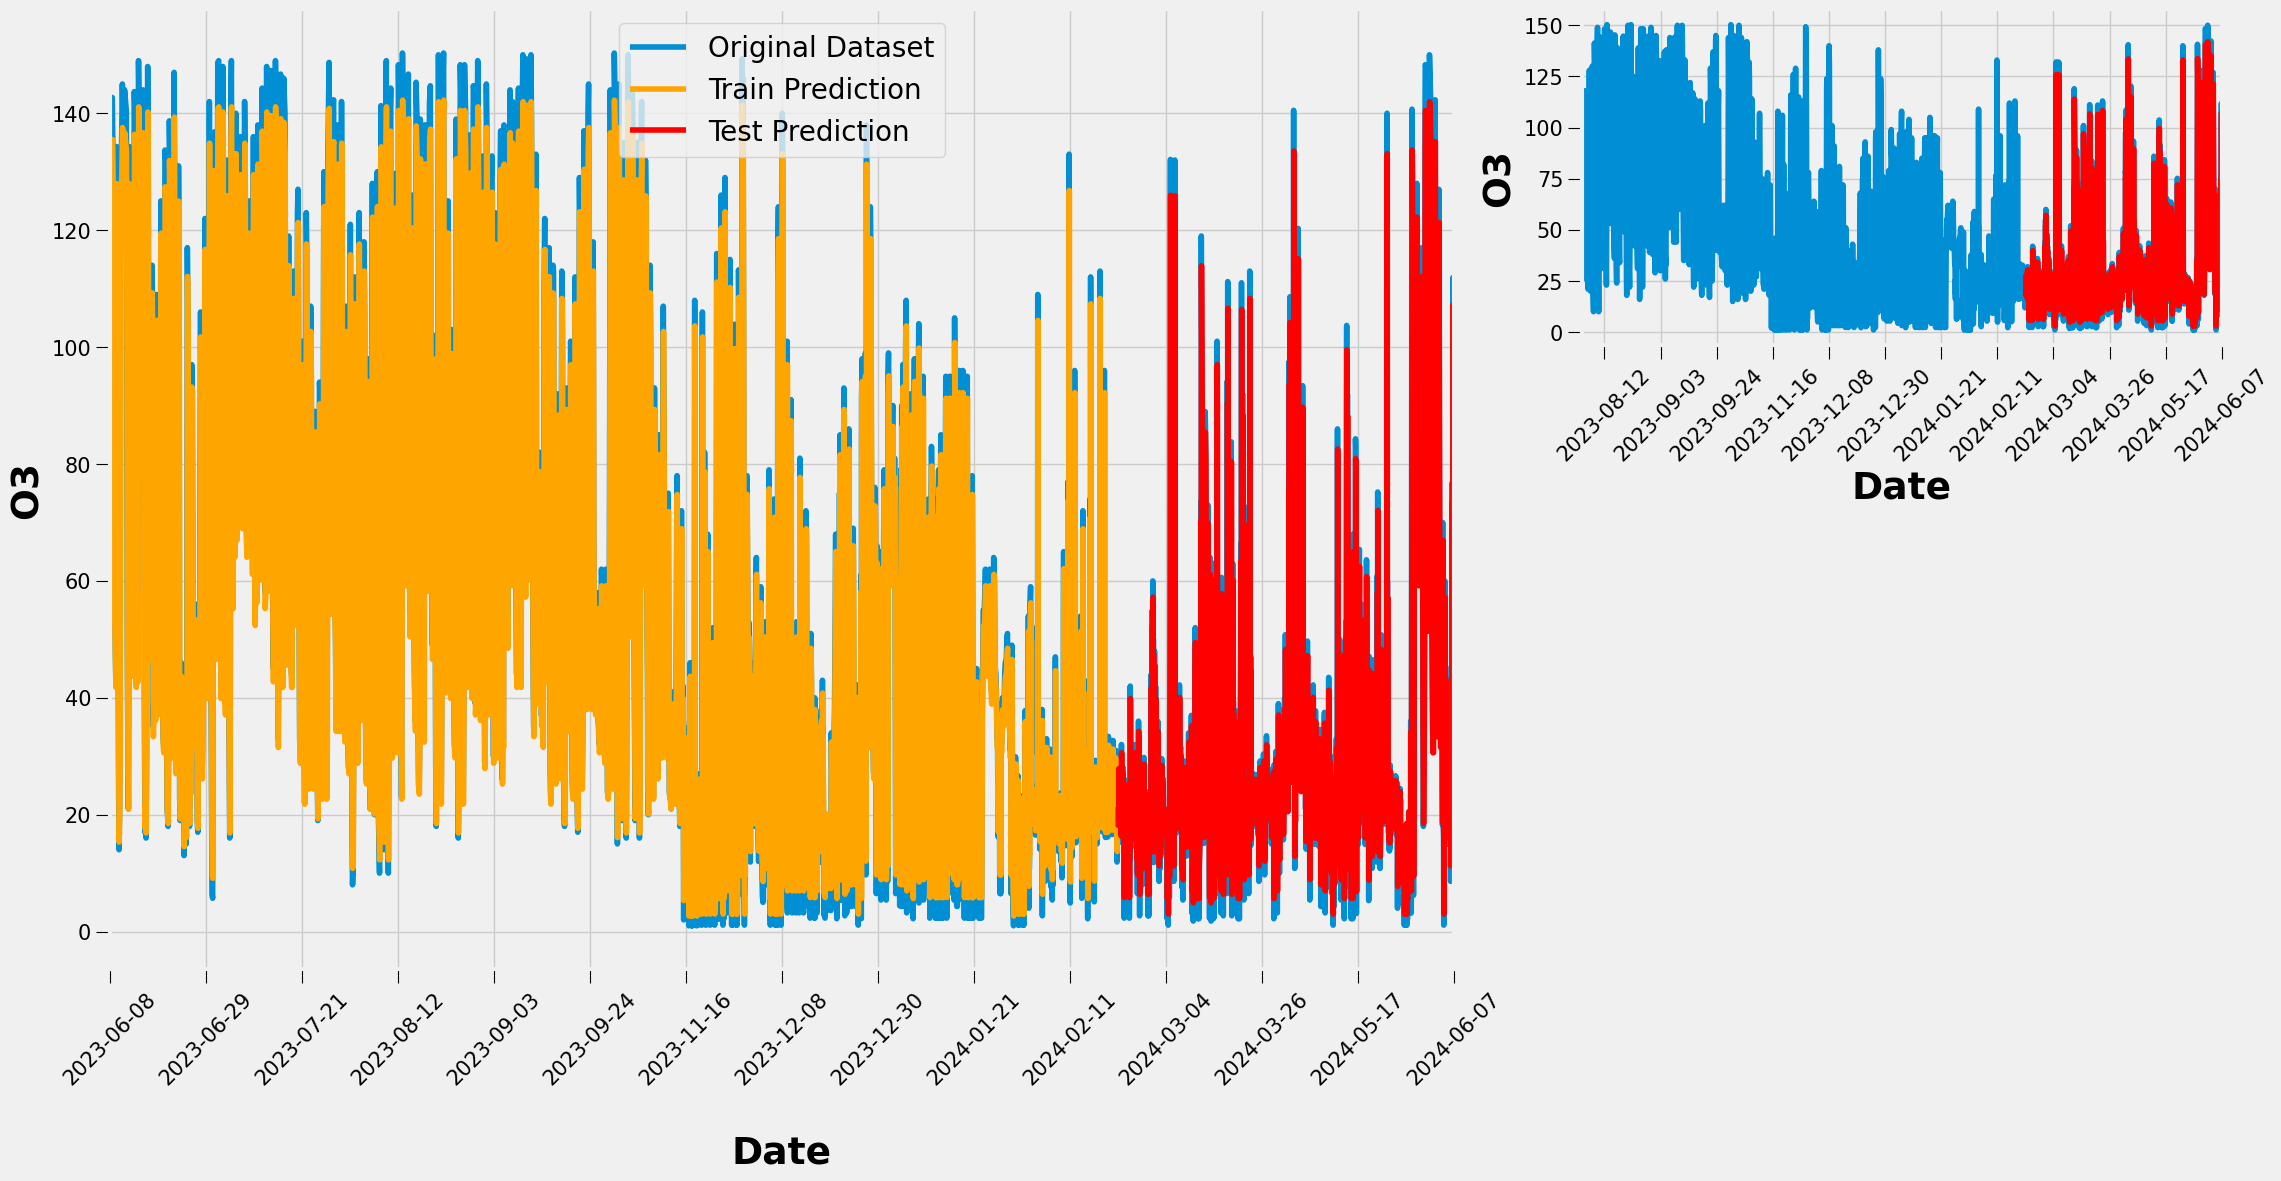

In [200]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('O3', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('O3', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 6. PM10 Prediction

In [201]:
dataset = np.log1p(data[['PM10']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

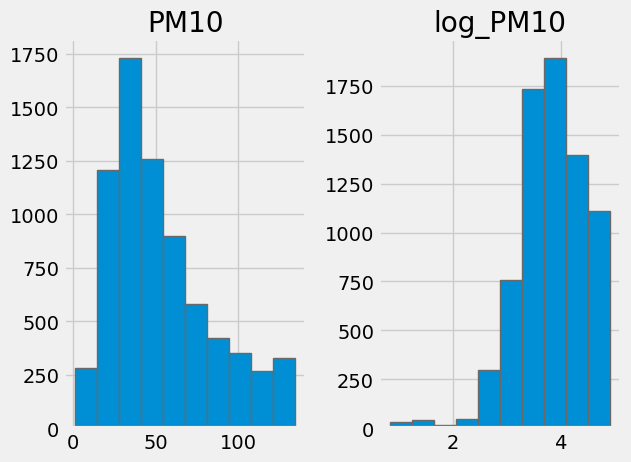

In [202]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'PM10' : data['PM10'].values, 'log_PM10' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [203]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [204]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [205]:
trainX

array([[3.95699637],
       [3.93182563],
       [4.00369019],
       ...,
       [3.87120101],
       [3.44041809],
       [3.54095932]])

In [206]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [207]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 7ms/step - loss: 11.3272
Epoch 2/1000
172/172 - 1s - 4ms/step - loss: 6.0300
Epoch 3/1000
172/172 - 1s - 6ms/step - loss: 2.8072
Epoch 4/1000
172/172 - 0s - 2ms/step - loss: 1.1750
Epoch 5/1000
172/172 - 0s - 2ms/step - loss: 0.4587
Epoch 6/1000
172/172 - 0s - 3ms/step - loss: 0.2802
Epoch 7/1000
172/172 - 0s - 2ms/step - loss: 0.2453
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.2347
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.2257
Epoch 10/1000
172/172 - 0s - 2ms/step - loss: 0.2150
Epoch 11/1000
172/172 - 1s - 5ms/step - loss: 0.2018
Epoch 12/1000
172/172 - 1s - 3ms/step - loss: 0.1836
Epoch 13/1000
172/172 - 1s - 3ms/step - loss: 0.1624
Epoch 14/1000
172/172 - 0s - 2ms/step - loss: 0.1432
Epoch 15/1000
172/172 - 0s - 2ms/step - loss: 0.1284
Epoch 16/1000
172/172 - 0s - 2ms/step - loss: 0.1171
Epoch 17/1000
172/172 - 0s - 2ms/step - loss: 0.1086
Epoch 18/1000
172/172 - 1s - 5ms/step - loss: 0.1025
Epoch 19/1000
172/172 - 1s - 6ms/step - loss: 0.0982
E

### Model Performance

In [208]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 14.57 RMSE
Test Score: 17.95 RMSE


In [209]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
17.95 < 29.34


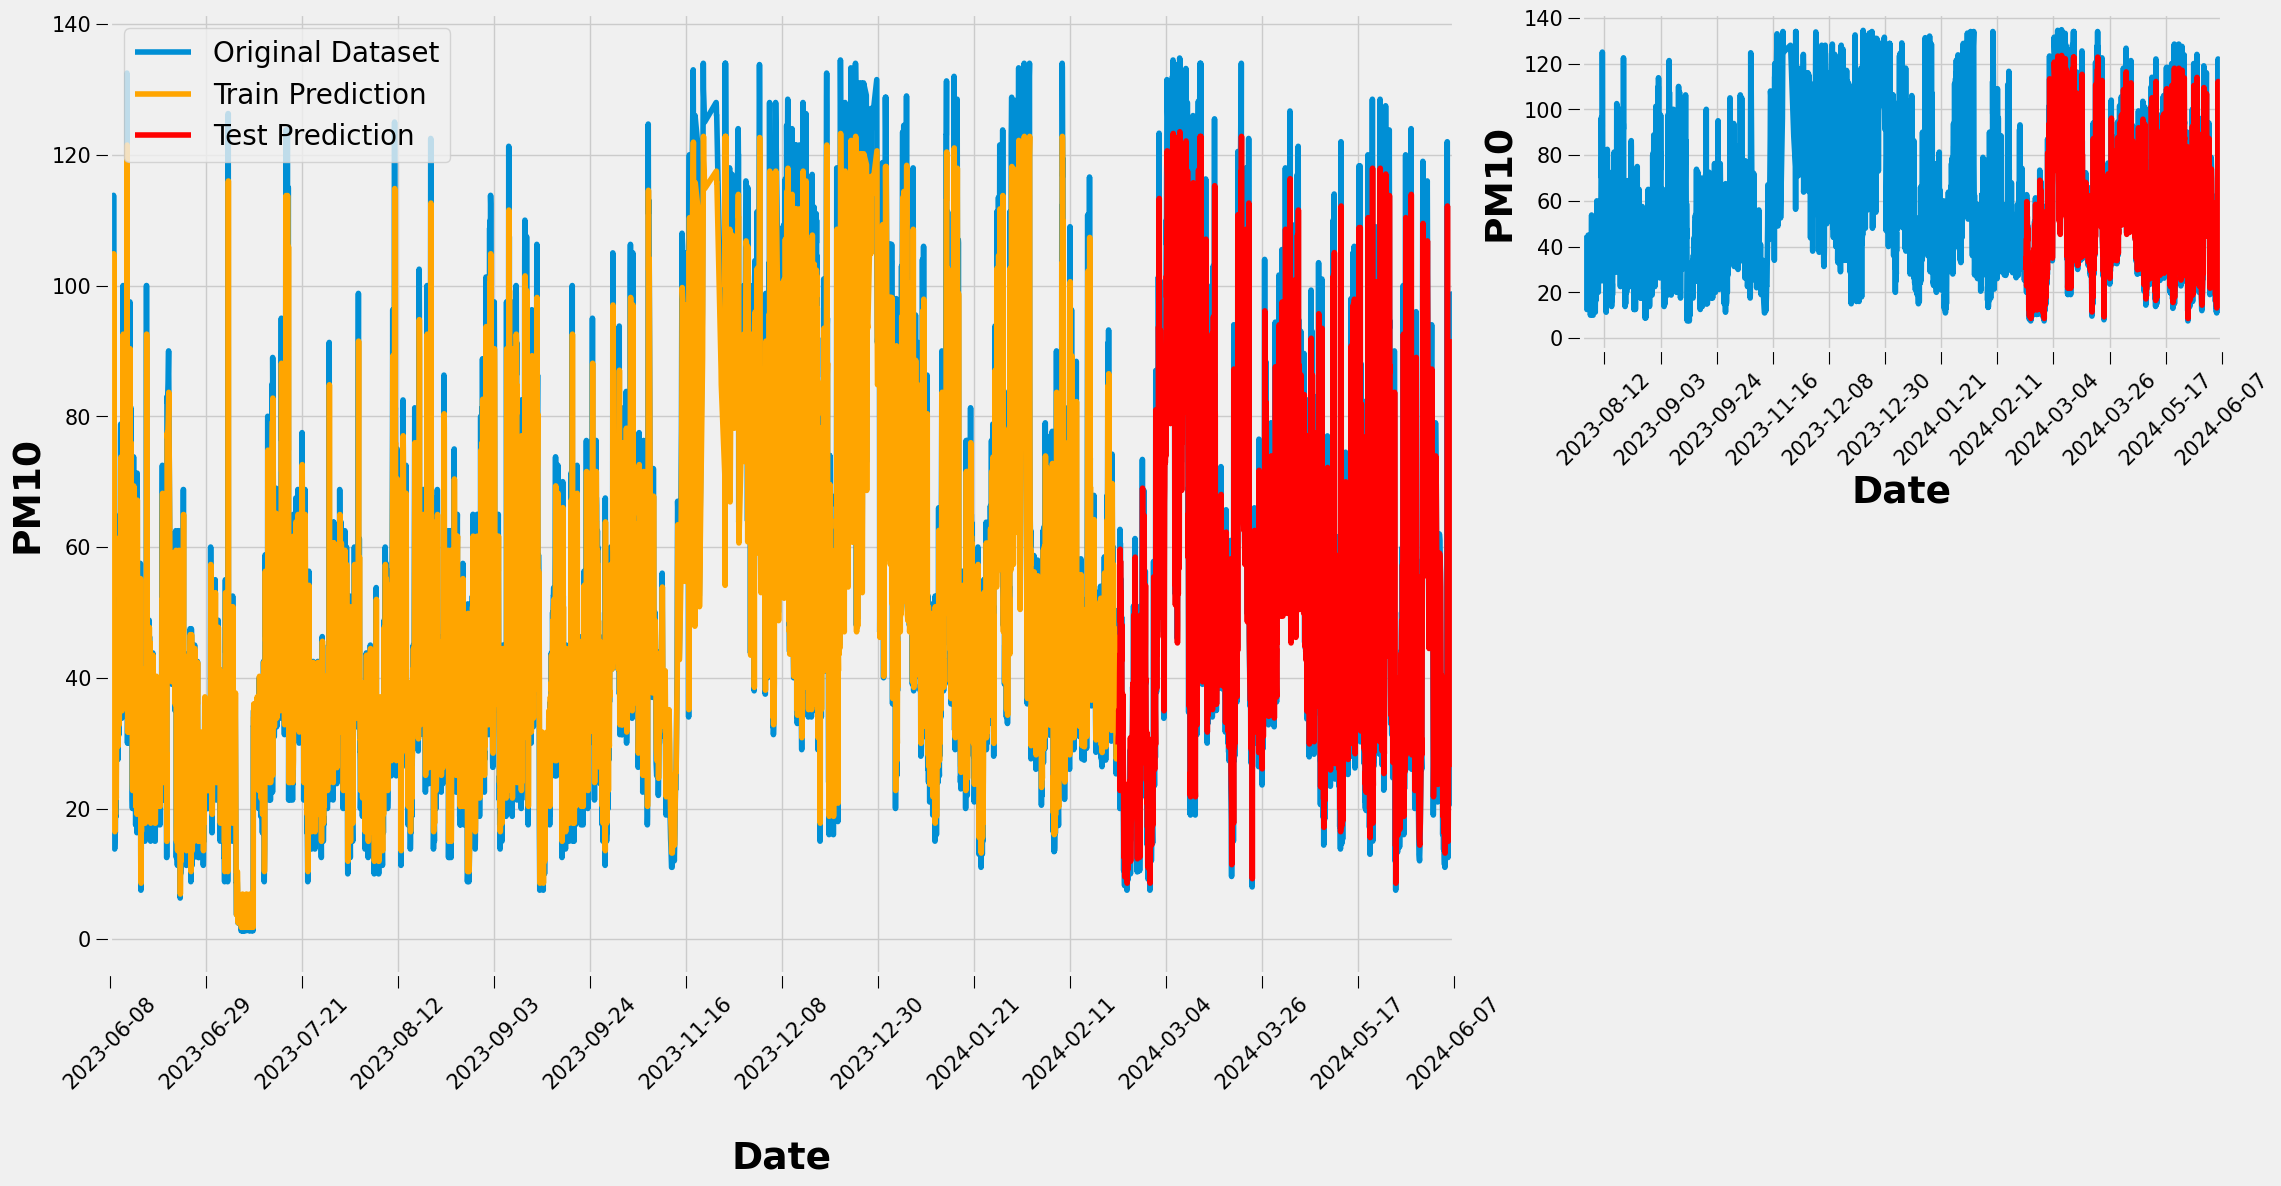

In [210]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 7. Precipitation Prediction

## 8. Pressure Prediction

In [211]:
dataset = np.log1p(data[['Pressure']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

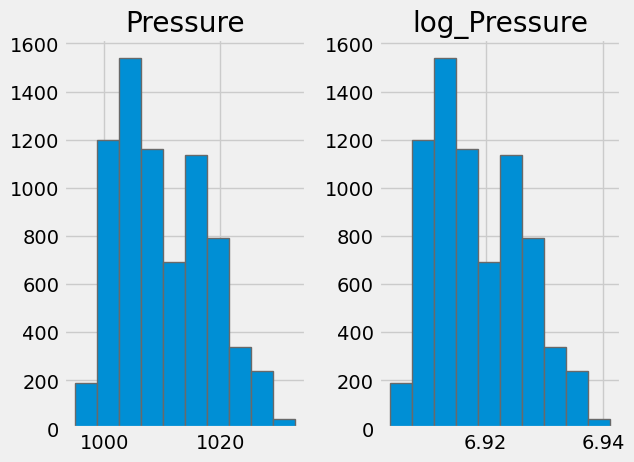

In [212]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Pressure' : data['Pressure'].values, 'log_Pressure' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [213]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [214]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [215]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [216]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 2s - 13ms/step - loss: 34.1034
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: 20.3277
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 11.1852
Epoch 4/1000
172/172 - 0s - 2ms/step - loss: 6.5478
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 3.8820
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 2.2506
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 1.2514
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.6589
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.3252
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.1491
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.0629
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.0243
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0085
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.0027
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 7.9031e-04
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 2.3763e-04
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 9.7074e-05
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 6.6101e-05
Epoch 19/1000
172/172 - 0s - 1ms/st

### Model Performance

In [217]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
Train Score: 2.45 RMSE
Test Score: 1.92 RMSE


In [218]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
1.92 < 5.89


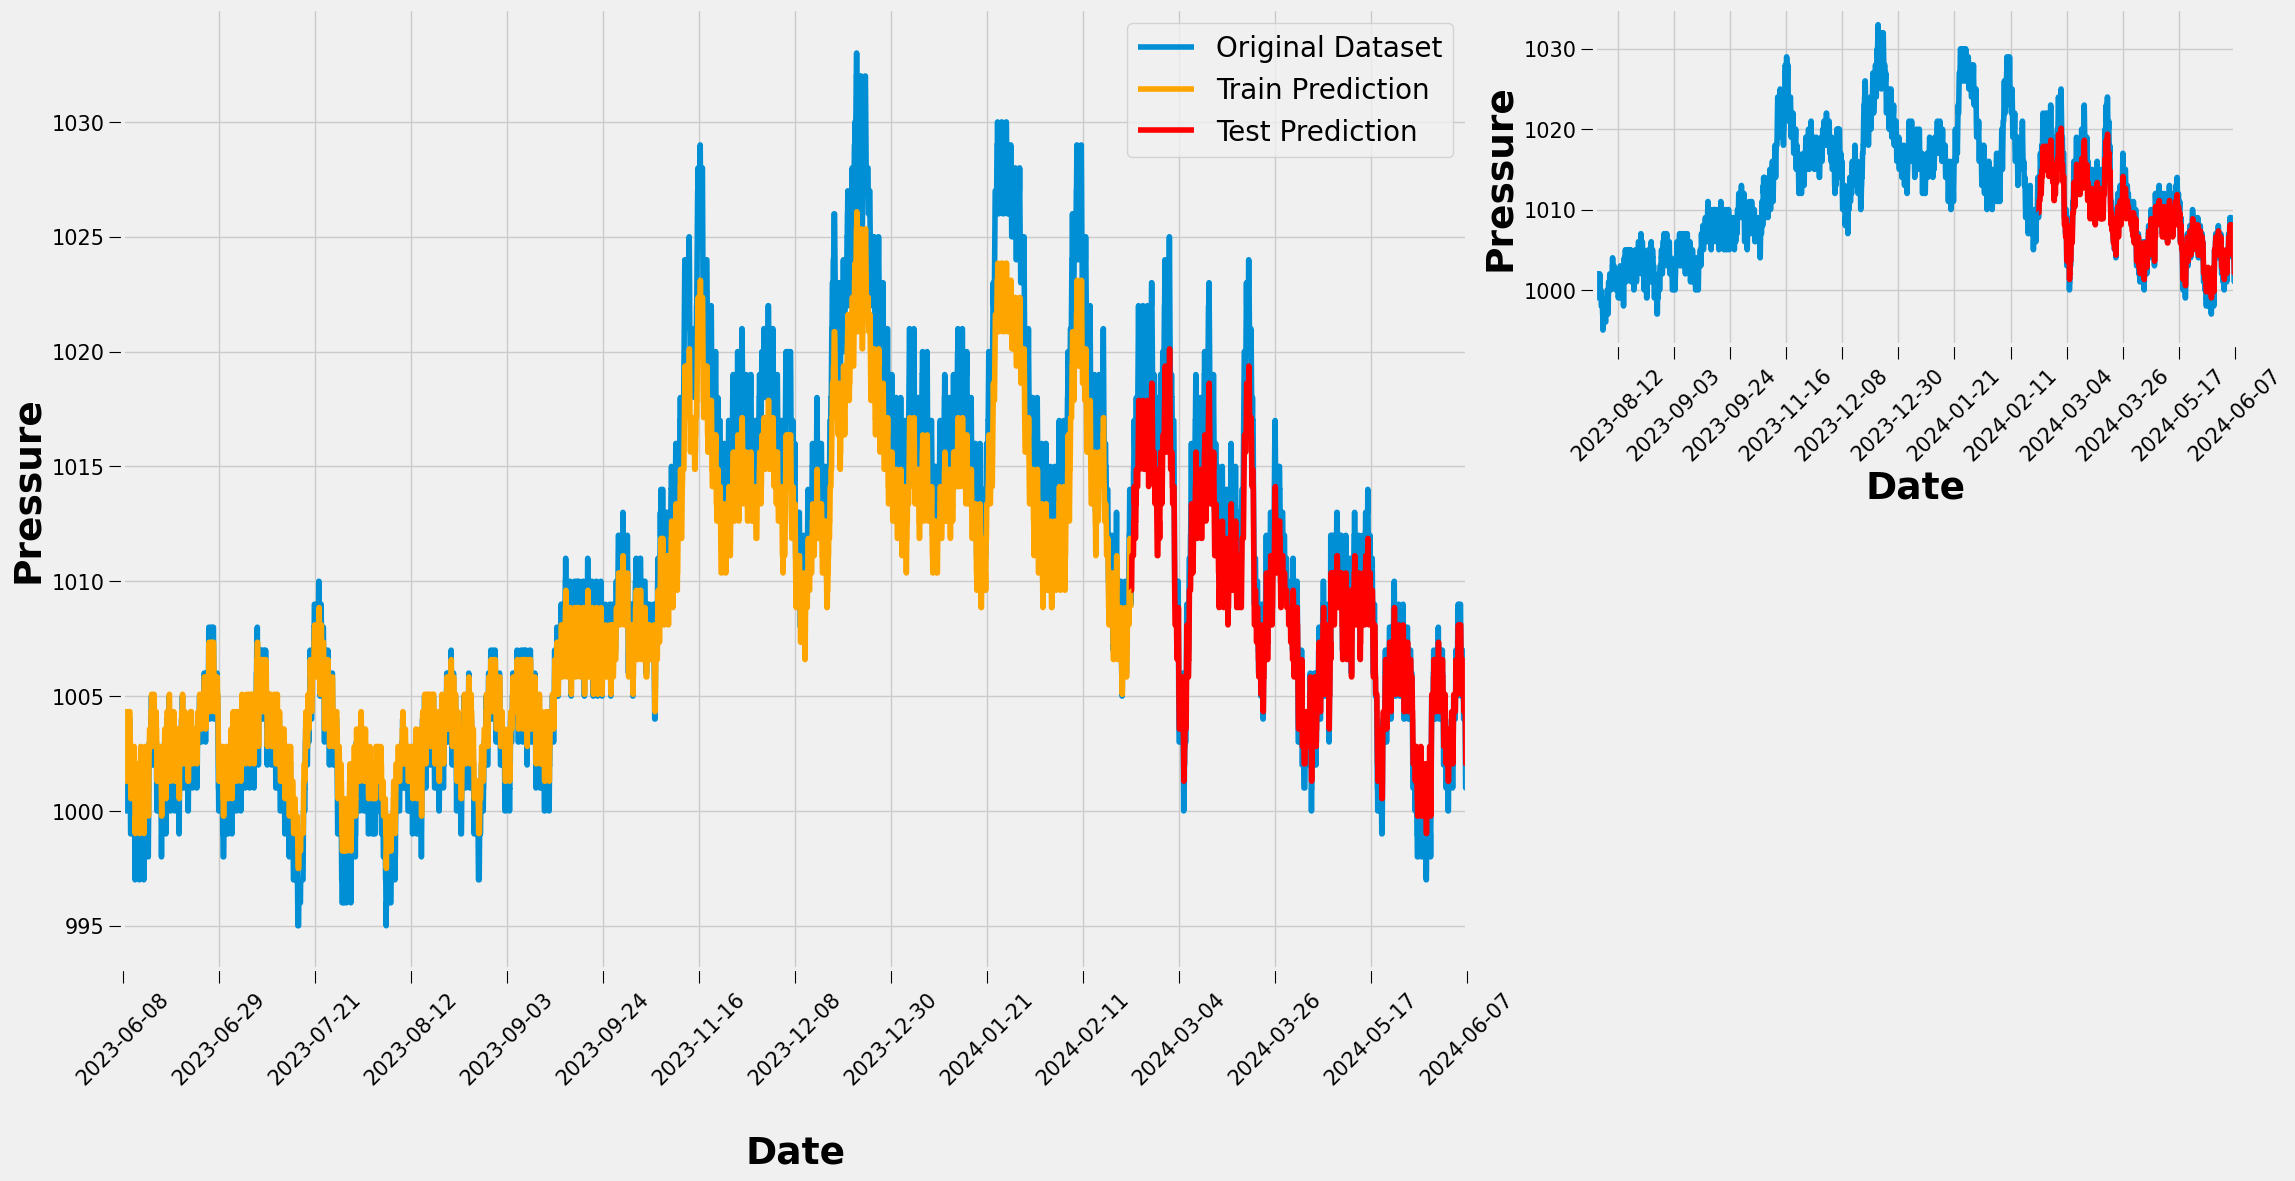

In [219]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Pressure', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Pressure', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 9. Relative Humidity	Temperature Prediction

In [220]:
dataset = np.log1p(data[['Relative Humidity']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

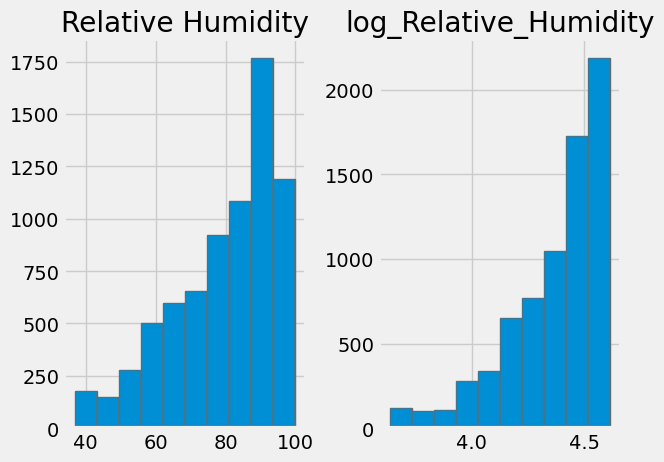

In [221]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Relative Humidity' : data['Relative Humidity'].values, 'log_Relative_Humidity' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [222]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [223]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [224]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [225]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 2s - 9ms/step - loss: 18.0192
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: 10.9582
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 6.2116
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 3.3574
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 1.5986
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.6021
Epoch 7/1000
172/172 - 0s - 2ms/step - loss: 0.1905
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.0683
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.0392
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.0334
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.0325
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.0324
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0322
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.0322
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.0321
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0320
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0318
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0318
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.0316


### Model Performance

In [226]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
Train Score: 3.81 RMSE
Test Score: 3.28 RMSE


In [227]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
3.28 < 11.62


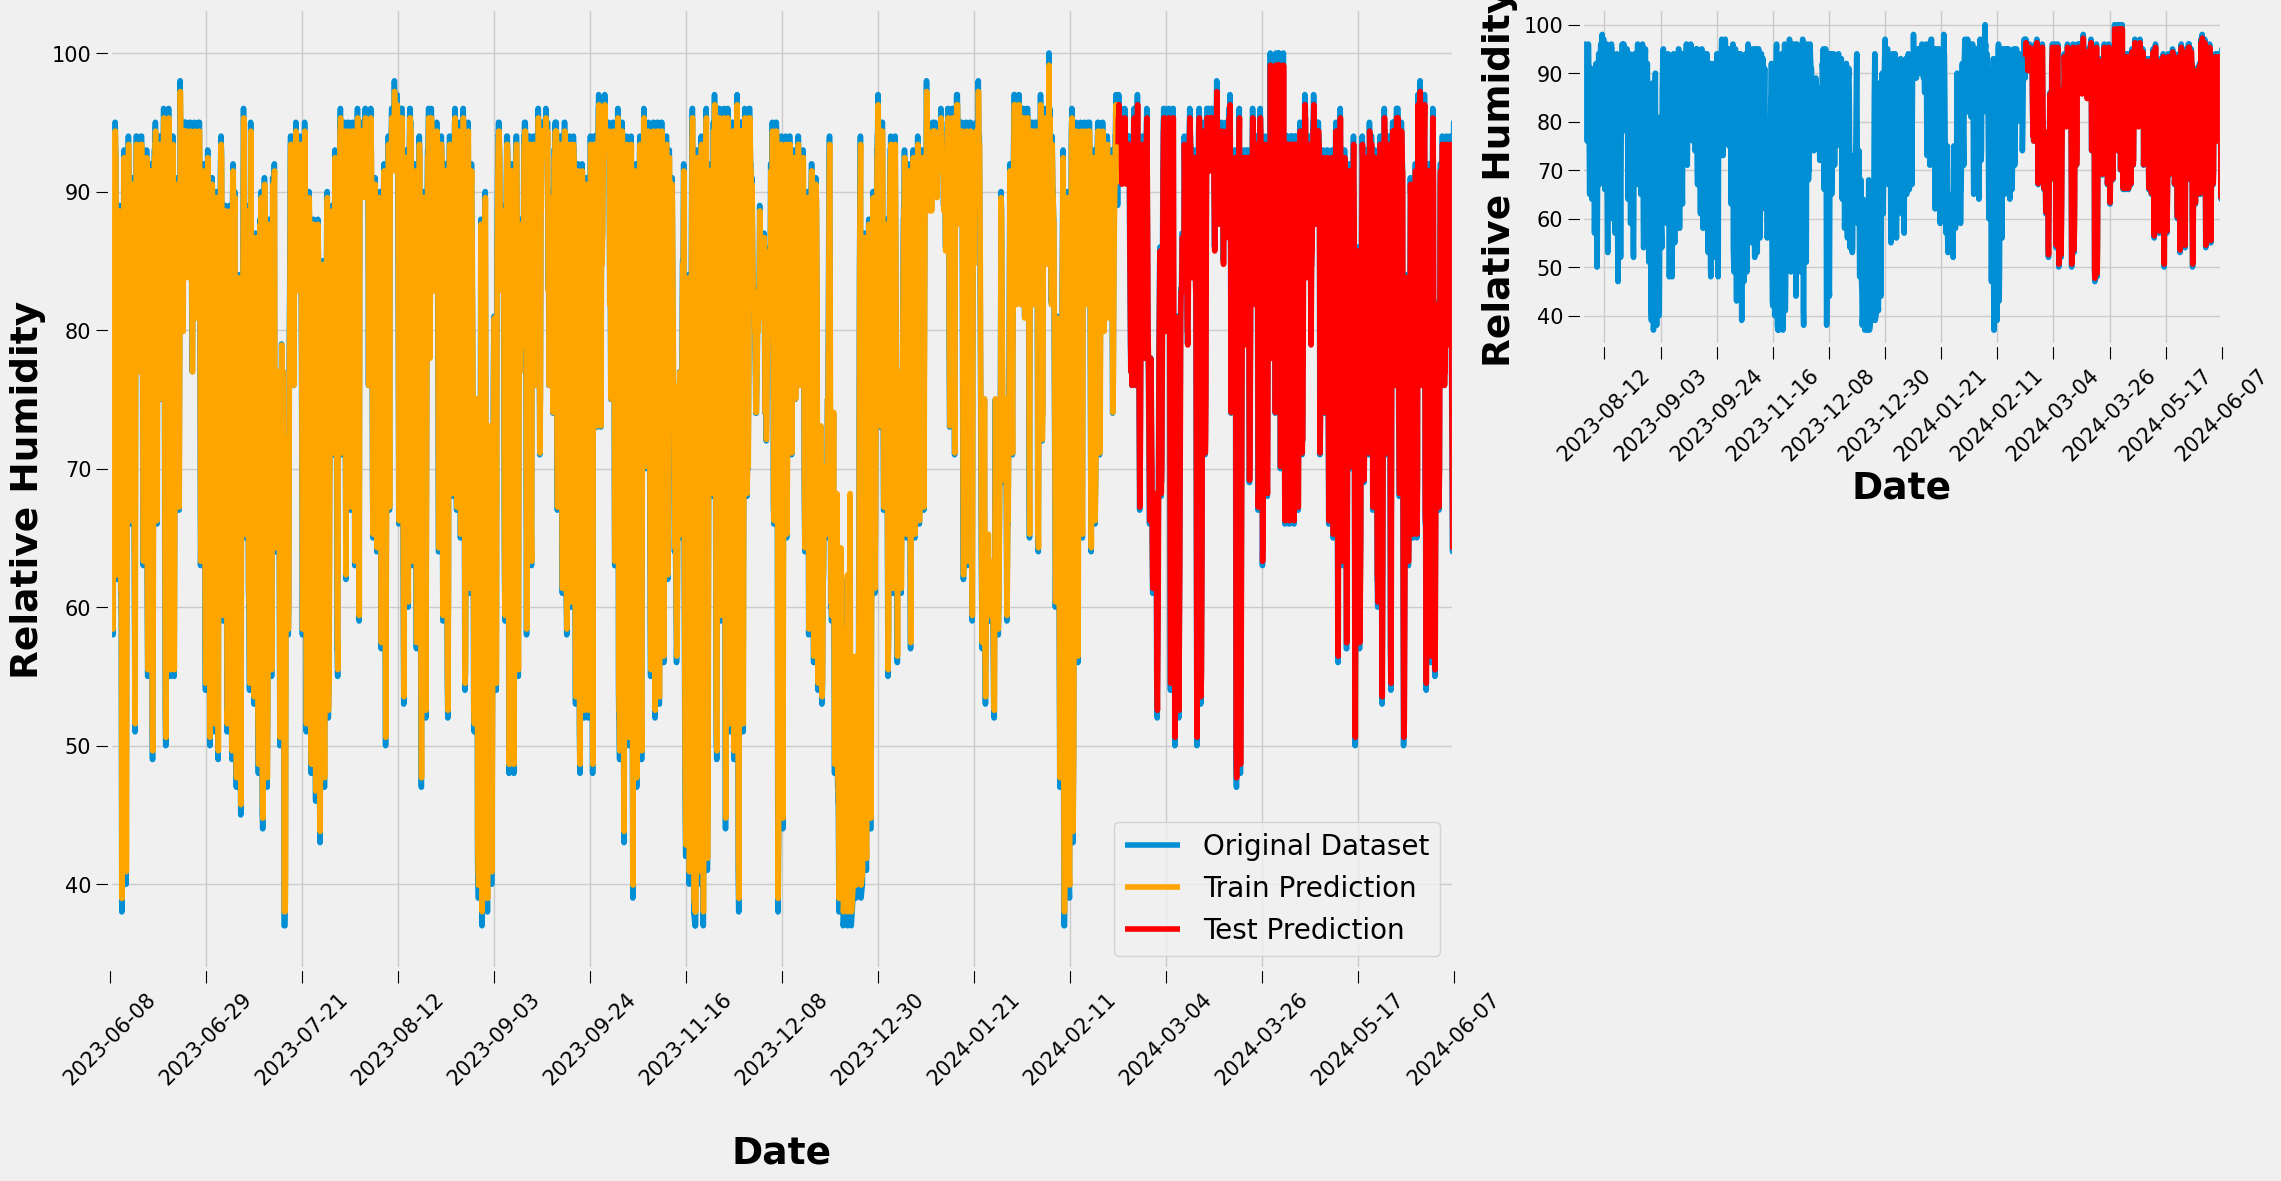

In [228]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Relative Humidity', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Relative Humidity', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

## 10. Wind Speed Prediction

In [229]:
dataset = np.log1p(data[['Wind Speed']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

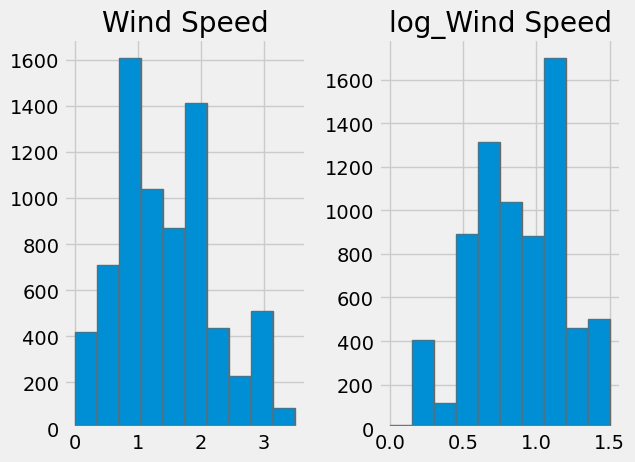

In [230]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Wind Speed' : data['Wind Speed'].values, 'log_Wind Speed' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [231]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [232]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [233]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [234]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 8ms/step - loss: 0.3674
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: 0.0747
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 0.0501
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 0.0494
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 0.0489
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.0483
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.0478
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.0477
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.0472
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.0471
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.0470
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.0468
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0467
Epoch 14/1000
172/172 - 0s - 2ms/step - loss: 0.0467
Epoch 15/1000
172/172 - 0s - 2ms/step - loss: 0.0466
Epoch 16/1000
172/172 - 0s - 2ms/step - loss: 0.0466
Epoch 17/1000
172/172 - 0s - 2ms/step - loss: 0.0466
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0465
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.0464
Ep

### Model performance

In [235]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Train Score: 0.48 RMSE
Test Score: 0.56 RMSE


In [236]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
0.56 < 0.77


In [237]:
trainPredict.shape

(5488, 1)

In [238]:
dataset.shape

(7321, 1)

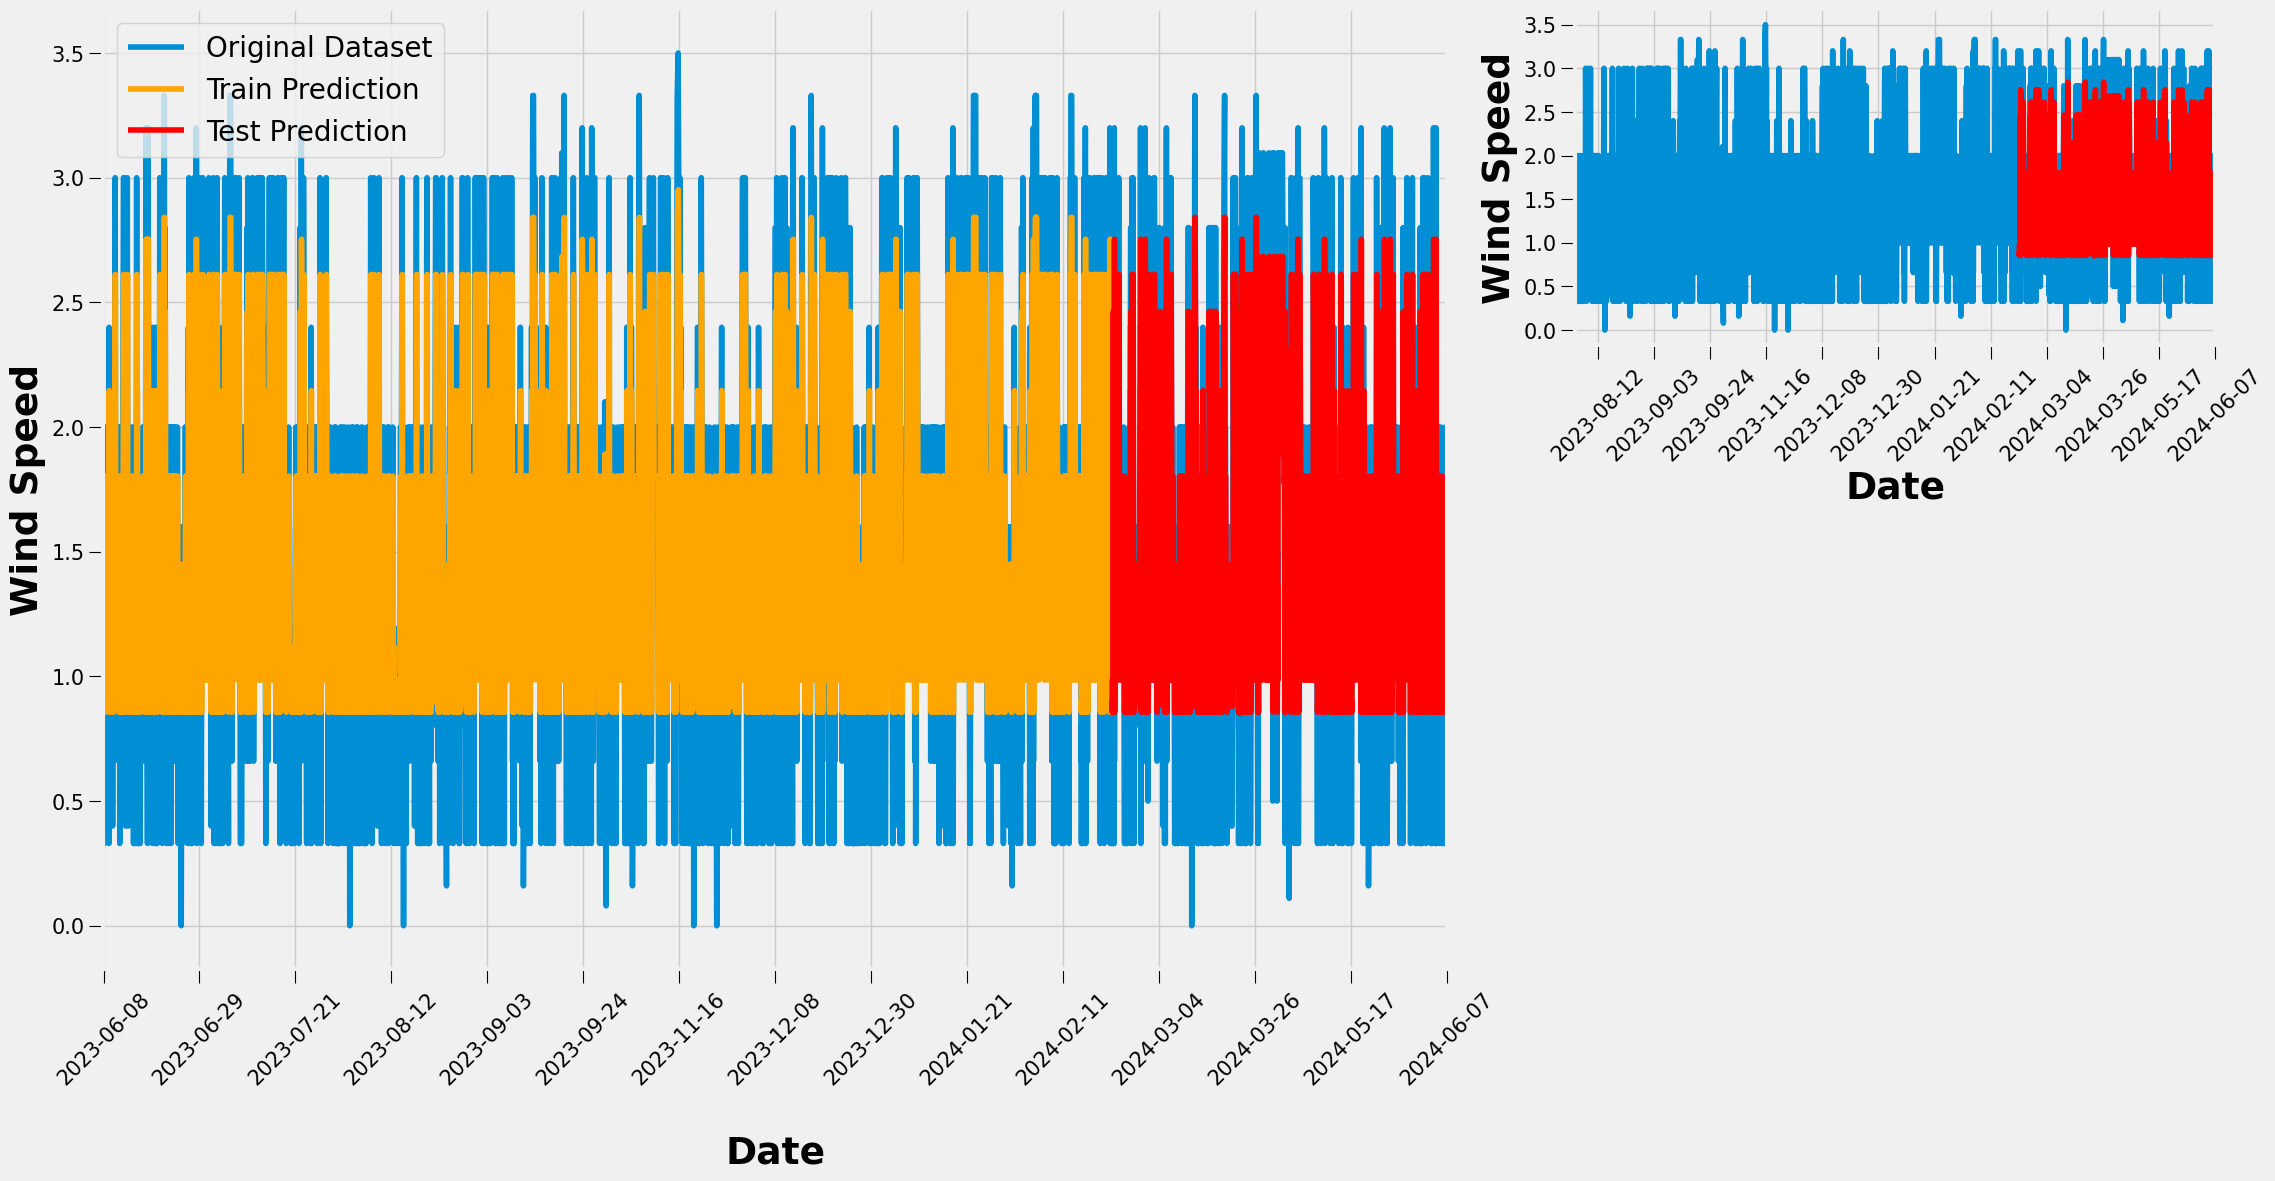

In [239]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Wind Speed', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Wind Speed', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);

In [240]:
trainPredict.shape

(5488, 1)

In [241]:
testPredict.shape

(1829, 1)

In [242]:
len(dataset)

7321